In [2]:
"""
Created on Tuesday, Apr 1st 2024
@author: Kaisheng Lin, School of Electronics, Peking University, China
@Summary: SE sequence, implemented with PyPulseq and compatible with MaSeq.
"""
import os
import sys
import matplotlib.pyplot as plt

# Use os.getcwd() to get the current working directory
main_directory = os.getcwd()
parent_directory = os.path.dirname(main_directory)
parent_directory = os.path.dirname(parent_directory)


# Define the subdirectories you want to add to sys.path
subdirs = ['MaSeq', 'marcos_client']

# Add the subdirectories to sys.path
for subdir in subdirs:
    full_path = os.path.join(parent_directory, subdir)
    sys.path.append(full_path)
#******************************************************************************

In [3]:

from seq.utils import sort_data_implicit, plot_nd, ifft_2d, combine_coils
import pypulseq as pp
import numpy as np
import seq.mriBlankSeq as blankSeq   
import configs.units as units
import scipy.signal as sig
import experiment_multifreq as ex
import configs.hw_config_pseq as hw
from flocra_pulseq.interpreter_pseq import PseqInterpreter
from pypulseq.convert import convert

class SEMultislicePSEQ(blankSeq.MRIBLANKSEQ):
    def __init__(self,output=None, expt=None, nScans=None, larmorFreq=None, rfExFA=None, rfReFA=None,
                 rfSincExTime=None, rfSincReTime=None, repetitionTime=None, echoTime=None,
                 fovInPlane=None, dfov=None, nPoints=None, axesOrientation=None,
                 bandwidth=None, DephTime=None, shimming=None, thickness=None,
                 sliceGap=None, phaseCycleEx=None, sliceGradComp=None, sliceSpoilComp=None,
                 sliceSpoilCompRD=None, riseTime=None, phaseGradComp=None):
        
        super(SEMultislicePSEQ, self).__init__()
        # Input the parameters

        self.output = output
        self.expt = expt
        self.nScans = np.array(nScans)
        self.larmorFreq = np.array(larmorFreq)
        self.rfExFA = np.array(rfExFA)
        self.rfReFA = np.array(rfReFA)
        self.rfSincExTime = np.array(rfSincExTime)
        self.rfSincReTime = np.array(rfSincReTime)
        self.repetitionTime = np.array(repetitionTime)
        self.echoTime = np.array(echoTime)
        self.fovInPlane = np.array(fovInPlane)
        self.dfov = np.array(dfov)
        self.nPoints = np.array(nPoints)
        self.axesOrientation = np.array(axesOrientation)
        self.bandwidth = np.array(bandwidth)
        self.DephTime = np.array(DephTime)
        self.shimming = np.array(shimming)
        self.thickness = np.array(thickness)
        self.sliceGap = np.array(sliceGap)
        self.phaseCycleEx = np.array(phaseCycleEx)
        self.sliceGradComp = np.array(sliceGradComp)
        self.sliceSpoilComp = np.array(sliceSpoilComp)
        self.sliceSpoilCompRD = np.array(sliceSpoilCompRD)
        self.riseTime = np.array(riseTime)
        self.phaseGradComp = np.array(phaseGradComp)


        self.addParameter(key='seqName', string='se', val='se')
        self.addParameter(key='nScans', string='Number of scans', val=nScans, field='IM')
        self.addParameter(key='larmorFreq', string='Larmor frequency (MHz)', val=larmorFreq, units=units.MHz, field='IM')
        self.addParameter(key='rfExFA', string='Excitation flip angle (deg)', val=rfExFA, field='RF')
        self.addParameter(key='rfReFA', string='Refocusing flip angle (deg)', val=rfReFA, field='RF')
        self.addParameter(key='rfSincExTime', string='RF sinc excitation time (ms)', val=rfSincExTime, units=units.ms, field='RF')
        self.addParameter(key='rfSincReTime', string='RF sinc refocusing time (ms)', val=rfSincReTime, units=units.ms, field='RF')
        self.addParameter(key='repetitionTime', string='Repetition time (ms)', val=repetitionTime, units=units.ms, field='SEQ')
        self.addParameter(key='echoTime', string='Echo time (ms)', val=echoTime, units=units.ms, field='SEQ')
        self.addParameter(key='fovInPlane', string='FOV[Rd,Ph] (mm)', val=fovInPlane, units=units.mm, field='IM')
        self.addParameter(key='thickness', string='Slice thickness (mm)', val=thickness, units=units.mm, field='IM')
        self.addParameter(key='sliceGap', string='Slice gap (mm)', val=sliceGap, units=units.mm, field='IM')
        self.addParameter(key='dfov', string='dFOV[x,y,z] (mm)', val=dfov, units=units.mm, field='IM',
                          tip="Position of the gradient isocenter")
        self.addParameter(key='nPoints', string='nPoints[rd, ph, sl]', val=nPoints, field='IM')
        self.addParameter(key='axesOrientation', string='Axes[rd,ph,sl]', val=axesOrientation, field='IM',
                          tip="0=x, 1=y, 2=z")
        self.addParameter(key='bandwidth', string='Acquisition Bandwidth (kHz)', val=bandwidth, units=units.kHz, field='IM',
                          tip="The bandwidth of the acquisition (kHz). This value affects resolution and SNR.")
        self.addParameter(key='shimming', string='Shimming', val=shimming, field='SEQ')
        self.addParameter(key='phaseCycleEx', string='Phase cycle for excitation', val=phaseCycleEx, field='SEQ',
                          tip="List of phase values for cycling the excitation pulse.")
        self.addParameter(key='DephTime', string='Dephasing time (ms)', val=DephTime, units=units.ms, field='OTH')
        self.addParameter(key='sliceGradComp', string='Slice gradient compensation', val=sliceGradComp, field='OTH',
                          tip="Slice gradient compensation factor. This value is used to adjust the slice selection gradient amplitude.")
        self.addParameter(key='riseTime', string='Gradient rising time (ms)', val=riseTime, units=units.ms, field='OTH')
        self.addParameter(key='sliceGradComp', string='Slice gradient compensation', val=sliceGradComp, field='OTH',
                          tip="Slice gradient compensation factor. This value is used to adjust the slice selection gradient amplitude.")
        self.addParameter(key='phaseGradComp', string='Phase gradient compensation', val=phaseGradComp, field='OTH',
                          tip="Phase gradient compensation factor. This value is used to adjust the phase selection gradient amplitude.")
        self.addParameter(key='sliceSpoilComp', string='Slice spoiling gradient compensation', val=sliceSpoilComp, field='OTH',
                          tip="Slice spoiling gradient compensation factor. This value is used to adjust the slice selection gradient amplitude.")
        self.addParameter(key='sliceSpoilCompRD', string='RD Slice spoiling gradient compensation', val=sliceSpoilCompRD, field='OTH',
                          tip="Slice spoiling recovery gradient compensation factor. This value is used to adjust the slice selection gradient amplitude.")
        
    def sequenceInfo(self):
        print("Pulseq Reader")
        print("Author: PhD. J.M. Algarín")
        print("Contact: josalggui@i3m.upv.es")
        print("mriLab @ i3M, CSIC, Spain")
        print("Run a list of .seq files\n")
        

    def sequenceTime(self):
        return (self.mapVals['repetitionTime'] *1e-3 * 
                self.mapVals['nScans'] *
                self.mapVals['nPoints'][1]  / 60)

    def sequenceAtributes(self):
        super().sequenceAtributes()

        # Convert files to a list
        # self.files = self.files.strip('[]').split(',')
        # self.files = [s.strip() for s in self.files]

    def sequenceRun(self, plotSeq=0, demo=False, standalone=False):
        init_gpa = False
        self.demo = demo
        self.plotSeq = plotSeq
        self.standalone = standalone
        
        # Calculate slice positions
        slice_positions = self.dfov[2] + (self.thickness + self.sliceGap) * (np.arange(self.nPoints[2]) - (self.nPoints[2] - 1) // 2)

        # slice idx
        slice_idx = np.concatenate((np.arange(self.nPoints[2])[::2],np.arange(self.nPoints[2])[1::2]))
        self.mapVals['sliceIdx'] = slice_idx

        # Reorder slices for an interleaved acquisition (optional)
        slice_positions = slice_positions[slice_idx]
        
        # redefine fov using slice thickness and gap
        self.fov = [self.fovInPlane[0], self.fovInPlane[1], np.max(slice_positions)-np.min(slice_positions)+self.thickness]       
        
        '''
        Step 1: Define the interpreter for FloSeq/PSInterpreter.
        The interpreter is responsible for converting the high-level pulse sequence description into low-level
        instructions for the scanner hardware. You will typically update the interpreter during scanner calibration.
        '''

        max_grad_Hz = convert(from_value=hw.max_grad, from_unit='mT/m', gamma=hw.gammaB, to_unit='Hz/m')
 
        rfExTime_us = int(np.round(self.rfSincExTime * 1e6))
        rfReTime_us = int(np.round(self.rfSincReTime * 1e6))
        assert rfExTime_us in hw.max_sinc_rf_arr, f"RF excitation time '{rfExTime_us}' s is not found in the hw_config_pseq file; please search it in search_p90_pseq."
        assert rfReTime_us in hw.max_sinc_rf_arr_p180, f"RF refocusing time '{rfReTime_us}' s is not found in the hw_config_pseq file; please search it in search_p180_pseq."
        
        max_rf_Hz = hw.max_sinc_rf_arr[rfExTime_us] * 1e-6 * hw.gammaB
        rf_ref_correction_coeff = 1 * hw.max_sinc_rf_arr[rfExTime_us] / hw.max_sinc_rf_arr_p180[rfReTime_us]
        
        self.flo_interpreter = PseqInterpreter(
            tx_warmup=hw.blkTime,  # Transmit chain warm-up time (us)
            rf_center=hw.larmorFreq * 1e6 ,  # Larmor frequency (Hz)
            rf_amp_max=max_rf_Hz,  # Maximum RF amplitude (Hz)
            grad_max=max_grad_Hz,  # Maximum gradient amplitude (Hz/m)
            grad_t=10,  # Gradient raster time (us)
            orientation=self.axesOrientation, # gradient orientation
            grad_eff=hw.gradFactor, # gradient coefficient of efficiency
            use_multi_freq = True,
            add_rx_points = 0,
            tx_t= 1229/122.88, # us
            use_grad_preemphasis=False,
            grad_preemphasis_coeff={
                        'xx':( (np.array([0.383494796, 0.159428847, 0.06601789, 0.03040273]), 
                            np.array([384.543433, 4353.01123, 46948.52793, 485123.9174] ))),
                        'yy':( (np.array([0.383494796, 0.159428847, 0.06601789, 0.03040273]),
                            np.array([384.543433, 4353.01123, 46948.52793, 485123.9174] ))),
                        'zz':( (np.array([0.383494796, 0.159428847, 0.06601789, 0.03040273]),
                            np.array([384.543433, 4353.01123, 46948.52793, 485123.9174] ))),
                 },
            use_fir_decimation = (self.bandwidth < 30.007326007326007e3), # 30kHz
        )
        
        '''
        Step 2: Define system properties using PyPulseq (pp.Opts).
        These properties define the hardware capabilities of the MRI scanner, such as maximum gradient strengths,
        slew rates, and dead times. They are typically set based on the hardware configuration file (`hw_config`).
        '''
        self.system = pp.Opts(
            rf_dead_time=1000 * 1e-6,  # Dead time between RF pulses (s)
            max_grad=38,  # Maximum gradient strength (mT/m)
            grad_unit='mT/m',  # Units of gradient strength
            max_slew=hw.max_slew_rate,  # Maximum gradient slew rate (mT/m/ms)
            slew_unit='mT/m/ms',  # Units of gradient slew rate
            grad_raster_time=hw.grad_raster_time, # hw.grad_raster_time,  # Gradient raster time (s)
            rise_time=self.riseTime,  # Gradient rise time (s)
            rf_raster_time=10e-6,
            block_duration_raster=1e-6,
            adc_raster_time=1/(122.88e6),
            # adc_dead_time=0e-6,
            
            rf_ringdown_time=0e-6,
            

        )

        '''
        Step 3: Perform any calculations required for the sequence.
        In this step, students can implement the necessary calculations, such as timing calculations, RF amplitudes, and
        gradient strengths, before defining the sequence blocks.
        '''

        bw = self.bandwidth * 1e-6 # MHz
        bw_ov = self.bandwidth * 1e-6 # - hw.oversamplingFactor  # MHz
        sampling_period = 1 / bw_ov  # us, Dwell time

        '''
        Step 4: Define the experiment to get the true bandwidth
        In this step, student needs to get the real bandwidth used in the experiment. To get this bandwidth, an
        experiment must be defined and the sampling period should be obtained using get_rx_ts()[0]
        '''

        if not self.demo:
            expt = ex.ExperimentMultiFreq(
                lo_freq=hw.larmorFreq,  # Larmor frequency in MHz
                rx_t=sampling_period,  # Sampling time in us
                init_gpa=False,  # Whether to initialize GPA board (False for True)
                gpa_fhdo_offset_time=(1 / 0.2 / 3.1),  # GPA offset time calculation
                auto_leds=True  # Automatic control of LEDs (False or True)
            )
            sampling_period = expt.get_rx_ts()[0]  # us
            bw = 1 / sampling_period # / hw.oversamplingFactor  # MHz
            print("Acquisition bandwidth fixed to: %0.3f kHz" % (bw * 1e3))
            expt.__del__()
        self.mapVals['bw_MHz'] = bw
        self.mapVals['sampling_period_us'] = sampling_period

        '''
        Step 5: Define sequence blocks.
        In this step, you will define the building blocks of the MRI sequence, including the RF pulses and gradient pulses.
        '''
        TE = self.echoTime
        TR = self.repetitionTime
        tau = TE / 2
        DepTime = self.DephTime

        Nx, Ny, n_slices = self.nPoints

        sampling_time = sampling_period * 1e-6 * self.nPoints[0]
        readout_time = sampling_time + 2 * self.system.adc_dead_time
        t_ex = self.rfSincExTime
        t_exwd = t_ex + self.system.rf_ringdown_time + self.system.rf_dead_time
        t_ref = self.rfSincReTime
        t_refwd = t_ref + self.system.rf_ringdown_time + self.system.rf_dead_time

        rf90, gz90, _ = pp.make_sinc_pulse(
            flip_angle=self.rfExFA * np.pi / 180,
            system=self.system,
            duration=t_ex,
            slice_thickness=self.thickness,
            apodization=0.5,
            time_bw_product=4,
            phase_offset= np.pi / 2,
            return_gz=True,
        )
        gz_ex = pp.make_trapezoid(
            channel="z",
            system=self.system,
            amplitude=gz90.amplitude,
            flat_time=t_exwd,
            rise_time=self.system.rise_time,
        )
        rf180, gz180, _ = pp.make_sinc_pulse(
            flip_angle=self.rfReFA * np.pi / 180,
            system=self.system,
            duration=t_ref,
            slice_thickness=self.thickness,
            apodization=0.5,
            time_bw_product=4,
            phase_offset=0,
            use="refocusing",
            return_gz=True,
        )
        gz_ref = pp.make_trapezoid(
            channel="z",
            system=self.system,
            amplitude=gz180.amplitude,
            flat_time=t_refwd,
            rise_time=self.system.rise_time,
        )
        rf180.signal = rf180.signal * rf_ref_correction_coeff
        delta_kx = 1 / self.fov[0]
        delta_ky = 1 / self.fov[1]
        
        k_widthx = Nx * delta_kx
        k_widthy = Ny * delta_ky
        gx =  pp.make_trapezoid(channel='x', system=self.system, flat_area=k_widthx, flat_time=readout_time, rise_time=self.system.rise_time)
        adc = pp.make_adc(num_samples=Nx, duration=gx.flat_time, delay=gx.rise_time)


        phase_areas = (np.arange(Ny) - (Ny // 2)) * delta_ky
        gz_reph = pp.make_trapezoid(channel='z', system=self.system, area=-gz_ex.area * self.sliceGradComp, duration=DepTime * 2, rise_time=self.system.rise_time )
        gx_pre = pp.make_trapezoid(channel='x', system=self.system, area=gx.area / 2, duration=DepTime * 2, rise_time=self.system.rise_time)
        gy_pre = pp.make_trapezoid(channel='y', system=self.system, area=phase_areas[-1], duration=DepTime * 2, rise_time=self.system.rise_time)
        gz_spoil = pp.make_trapezoid(channel='z', system=self.system, area=gz90.area * self.sliceSpoilComp, duration=DepTime, rise_time=self.system.rise_time)
        gz_spoil_RD = pp.make_trapezoid(channel='z', system=self.system, area=gz90.area * self.sliceSpoilCompRD, duration=DepTime, rise_time=self.system.rise_time)

        delay1 = tau - pp.calc_duration(rf90) / 2 - pp.calc_duration(gx_pre)
        delay1 -= pp.calc_duration(gz_spoil) - pp.calc_duration(rf180) / 2
        delay1 = pp.make_delay(delay1)
        delay2 = tau - pp.calc_duration(rf180) / 2 - pp.calc_duration(gz_spoil)
        delay2 -= pp.calc_duration(gx) / 2
        delay2 = pp.make_delay(delay2)
        delay_TR = TR - pp.calc_duration(rf90) / 2 - pp.calc_duration(gx) / 2 - TE
        delay_TR -= pp.calc_duration(gy_pre)
        delay_TR = pp.make_delay(delay_TR)
        print(f'delay_1: {delay1}')
        print(f'delay_2: {delay1}')
        print(f'delay_TR: {delay_TR}')


        def runBatches_pseq(waveforms, n_readouts, frequency=hw.larmorFreq, bandwidth=0.03):
            """
            Execute multiple batches of waveforms for MRI data acquisition, handle scanning, and store oversampled data.

            Parameters:
            -----------
            waveforms : dict
                A dictionary of waveform sequences, where each key corresponds to a batch identifier and
                the value is the waveform data generated using PyPulseq.
            n_readouts : dict
                A dictionary that specifies the number of readout points for each batch. Keys correspond to
                the batch identifiers, and values specify the number of readout points for each sequence.
            frequency : float, optional
                Larmor frequency in MHz for the MRI scan (default is the system's Larmor frequency, hw.larmorFreq).
            bandwidth : float, optional
                Bandwidth in Hz used to calculate the sampling time (1 / bandwidth gives the sampling period).

            Returns:
            --------
            bool
                Returns True if all batches were successfully executed, and False if an error occurred (e.g.,
                sequence waveforms are out of hardware bounds).

            Notes:
            ------
            - The method will initialize the Red Pitaya hardware if not in demo mode.
            - The method converts waveforms from PyPulseq format to Red Pitaya compatible format.
            - If plotSeq is True, the sequence will be plotted instead of being executed.
            - In demo mode, the acquisition simulates random data instead of using actual hardware.
            - Oversampled data is stored in the class attribute `self.mapVals['data_over']`.
            - Data points are acquired in batches, with error handling in case of data loss, and batches are repeated if necessary.
            """
            

            # Initialize a list to hold oversampled data
            data_over = []
            real_bandwidth = bandwidth * self.flo_interpreter._fir_decimation_rate 
            
            # Iterate through each batch of waveforms
            for seq_num in waveforms.keys():
                # Initialize the experiment if not in demo mode
                if not self.demo:
                    self.expt = ex.ExperimentMultiFreq(
                        lo_freq=frequency,  # Larmor frequency in MHz
                        rx_t=1 / real_bandwidth,  # Sampling time in us
                        init_gpa=False,  # Whether to initialize GPA board (False for now)
                        gpa_fhdo_offset_time=(1 / 0.2 / 3.1),  # GPA offset time calculation
                        auto_leds=True,  # Automatic control of LEDs
                        allow_user_init_cfg=True # Allow lo*_freq and lo*_rst to be modified
                    )
                print(f"Center frequecy set: {frequency} MHz")
                # Convert the PyPulseq waveform to the Red Pitaya compatible format
                self.pypulseq2mriblankseq_ms(waveforms=waveforms[seq_num], shimming=self.shimming)

                # Load the waveforms into Red Pitaya
                if not self.floDict2Exp_ms():
                    print("ERROR: Sequence waveforms out of hardware bounds")
                    return False
                else:
                    encoding_ok = True
                    # print("Sequence waveforms loaded successfully")
                if self.plotSeq and not self.demo:
                    self.expt.plot_sequence()

                # If not plotting the sequence, start scanning
                if not self.plotSeq:
                    for scan in range(self.nScans):
                        print(f"Scan {scan + 1}, batch {seq_num.split('_')[-1]}/{1} running...")
                        acquired_points = 0
                        expected_points = n_readouts[seq_num] * self.flo_interpreter._fir_decimation_rate * hw.oversamplingFactor  # Expected number of points

                        # Continue acquiring points until we reach the expected number
                        while acquired_points != expected_points:
                            if not self.demo:
                                rxd, msgs = self.expt.run()  # Run the experiment and collect data
                            else:
                                # In demo mode, generate random data as a placeholder
                                rxd = {'rx0': np.random.randn(expected_points + self.flo_interpreter.get_add_rx_points()) + 1j * np.random.randn(expected_points + + self.flo_interpreter.get_add_rx_points())}
                            
                            # Update acquired points
                            self.rxChName = 'rx0'
                            rx_raw_data = rxd[self.rxChName]
                            rxdata = self.flo_interpreter.rx_points_added_for_img(rx_raw_data, self.nPoints[0])
                            rxdata = np.reshape(rxdata, newshape=(-1))
                            acquired_points = np.size(rxdata)

                            # Check if acquired points coincide with expected points
                            if acquired_points != expected_points:
                                print("WARNING: data apoints lost!")
                                print("Repeating batch...")

                        # Concatenate acquired data into the oversampled data array
                        data_over = np.concatenate((data_over, rxdata), axis=0)
                        print(f"Acquired points = {acquired_points}, Expected points = {expected_points}")
                        print(f"Scan {scan + 1}, batch {seq_num[-1]}/{1} ready!")

                    # Decimate the oversampled data and store it
                    self.mapVals['data_over'] = data_over
                    self.mapVals['data_full'] = np.concatenate((self.mapVals['data_full'], self.mapVals['data_over']), axis=0)
                    
                elif self.plotSeq and self.standalone:
                    # Plot the sequence if requested and return immediately
                    self.sequencePlot(standalone=self.standalone)

                if not self.demo:
                    self.expt.__del__()

            return True
        
        
        # Initialize batches dictionary to store different parts of the sequence.
        batches = {}
        n_rd_points_dict = {}  # Dictionary to track readout points for each batch
        n_rd_points = 0
        batch_idx = 1 # In this sequence, batch_idx is equivalent to the index of slice coding index 

        
        '''
        Step 7: Define your createBatches method.
        In this step you will populate the batches adding the blocks previously defined in step 4, and accounting for
        number of acquired points to check if a new batch is required.
        '''
        def createBatches():
            """
            Create batches for the full pulse sequence.

            Instructions:
            - This function creates the complete pulse sequence by iterating through repetitions.
            - Each iteration adds new blocks to the sequence, including the RF pulse, ADC block, and repetition delay.
            - If a batch exceeds the maximum number of readout points, a new batch is started.

            Returns:
                waveforms (dict): Contains the waveforms for each batch.
                n_rd_points_dict (dict): Dictionary of readout points per batch.
            """
            
            n_rd_points = 0
            rf_ex_cycle = np.tile(np.array(self.phaseCycleEx), int(np.ceil((Ny+1) / len(self.phaseCycleEx)))) / 180 * np.pi

            # Multi-slice is not available so far!
            assert n_slices == 1, "Multi-slice is not available so far!"
            for k_ex in range(Ny):
                    
                for s in range(n_slices):
                    rf90.freq_offset = (
                        gz90.amplitude * slice_positions[s]
                    )
                    rf180.freq_offset = (
                        gz180.amplitude * slice_positions[s]
                    )
                    rf90.phase_offset = (
                        np.pi / 2 + rf_ex_cycle[k_ex]
                        - 2 * np.pi * rf90.freq_offset * pp.calc_rf_center(rf90)[0]
                    )
                    rf_ref_offset_for_slice = - 2 * np.pi * rf180.freq_offset * pp.calc_rf_center(rf180)[0]
                    rf_ref_offset = rf_ref_offset_for_slice + 0
                    adc.phase_offset = rf_ex_cycle[k_ex]
                    # rf_ref.phase_offset = (
                    #     0 
                    #     - 2 * np.pi * rf_ref.freq_offset * pp.calc_rf_center(rf_ref)[0]
                    # )
                    batches[batch_num].add_block(rf90, gz_ex)
                    gy_pre = pp.make_trapezoid(channel='y', system=self.system, area=-phase_areas[k_ex], duration=self.DephTime*2, rise_time=self.system.rise_time)
                    batches[batch_num].add_block(gx_pre, gy_pre, gz_reph)
                    batches[batch_num].add_block(delay1)
                    batches[batch_num].add_block(gz_spoil)
                    batches[batch_num].add_block(rf180, gz_ref)
                    batches[batch_num].add_block(gz_spoil)
                    batches[batch_num].add_block(delay2)
                    batches[batch_num].add_block(gx, adc)
                    assert n_rd_points + self.nPoints[0] < hw.maxRdPoints
                    n_rd_points = n_rd_points + self.nPoints[0]
                    gy_pre = pp.make_trapezoid(channel='y', system=self.system, area=phase_areas[s]**self.phaseGradComp, duration=self.DephTime*2, rise_time=self.system.rise_time)
                    batches[batch_num].add_block(gy_pre, gz_spoil_RD)
                    batches[batch_num].add_block(delay_TR)
                    
                    

            (
                ok,
                error_report,
            ) = batches[batch_num].check_timing()  # Check whether the timing of the sequence is correct
            
            if plotSeq:
                if ok:
                    print("Timing check passed successfully")
                else:
                    print("Timing check failed. Error listing follows:")
                    [print(e) for e in error_report]
                print(batches[batch_num].test_report())
                batches[batch_num].plot()
                k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = batches[batch_num].calculate_kspace()

                plt.figure(10)
                plt.plot(k_traj[0],k_traj[1],linewidth=1)
                plt.plot(k_traj_adc[0],k_traj_adc[1],'.', markersize=1.4)
                plt.axis("equal")
                plt.title("k-space trajectory (kx/ky)")

                plt.figure(11)
                plt.plot(t_adc, k_traj_adc.T, linewidth=1)
                plt.xlabel("Time of acqusition (s)")
                plt.ylabel("Phase")
                
                plt.figure(12)
                t = np.linspace(0, 1, k_traj_adc.shape[1])  # 归一化时间
                plt.scatter(k_traj_adc[0], k_traj_adc[1], c=t, cmap='viridis', s=2)  # 用颜色表示时间
                plt.axis("equal")
                plt.colorbar(label='Normalized Time')  # 添加颜色条
                plt.title("k-space trajectory (kx/ky) with Gradient")
                plt.show()




            batches[batch_num].set_definition(key="Name", value="se")
            batches[batch_num].set_definition(key="FOV", value=self.fov)
            batches[batch_num].write(batch_num + ".seq")
            self.waveforms[batch_num], param_dict = self.flo_interpreter.interpret(batch_num + ".seq")
            print(f"{batch_num}.seq ready!")
            print(f"{len(batches)} batches created with {n_rd_points} read points. Sequence ready!")

            # Update the number of acquired ponits in the last batch
            self.n_rd_points_dict[batch_num] = n_rd_points
            self.lastseq = batches[batch_num]

            return 

        '''
        Step 8: Run the batches
        This step will handle the different batches, run it and get the resulting data. This should not be modified.
        Oversampled data will be available in self.mapVals['data_over']
        '''
        self.waveforms = {}  # Dictionary to store generated waveforms
        self.n_rd_points_dict = {}
        # self.rf_slice_freq_offset = []
        self.mapVals['data_full'] = []
        
            
        batch_num = f"batch_{batch_idx}"  # Initial batch name
        print(f"Creating {batch_num}.seq...")
        batches[batch_num] = pp.Sequence(system=self.system)

        createBatches()

        batches_list = [{key: value} for key, value in self.waveforms.items()]
        n_rd_points_list = [{key: value} for key, value in self.n_rd_points_dict.items()]
        
        assert runBatches_pseq(batches_list[0],
                            n_rd_points_list[0],
                            frequency=(self.larmorFreq)*1e-6 ,  # MHz
                            bandwidth=bw_ov,  # MHz
                            )
            
        self.mapVals['n_readouts'] = list(self.n_rd_points_dict.values())
        self.mapVals['n_batches'] = 1
        return True

        
    def sequenceAnalysis(self, mode=None):
        self.mode = mode
        self.etl = 1
        #self.axesOrientation = [0,1,2] # for ssfp
        self.unlock_orientation = 0 # for ssfp
        resolution = self.fov / self.nPoints
        self.mapVals['resolution'] = resolution

        # Get data
        data_full_pre = self.mapVals['data_full']
        nRD, nPH, nSL = self.nPoints
        nRD = nRD + 2 * hw.addRdPoints
        n_batches = self.mapVals['n_batches']
        # fir decimator
        if self.flo_interpreter._fir_decimation_rate > 1:
            data_waiting_for_fir = np.reshape(data_full_pre, newshape=(-1, self.flo_interpreter._fir_decimation_rate * nRD))
            data_full = self.flo_interpreter.fir_decimator(input_matrix=data_waiting_for_fir, decimation_rate=3)
        else:
            data_full = data_full_pre

        
        # Reorganize data_full
        data_prov = np.zeros([self.nScans, nRD * nPH * nSL], dtype=complex)
        if n_batches > 1:
            n_rds = self.mapVals['n_readouts']
            data_full_a = data_full[0:sum(n_rds[0:-1]) * self.nScans]
            data_full_b = data_full[sum(n_rds[0:-1]) * self.nScans:]
            data_full_a = np.reshape(data_full_a, newshape=(n_batches - 1, self.nScans, -1, nRD))
            data_full_b = np.reshape(data_full_b, newshape=(1, self.nScans, -1, nRD))
            for scan in range(self.nScans):
                data_scan_a = np.reshape(data_full_a[:, scan, :, :], -1)
                data_scan_b = np.reshape(data_full_b[:, scan, :, :], -1)
                data_prov[scan, :] = np.concatenate((data_scan_a, data_scan_b), axis=0)
        else:
            data_full = np.reshape(data_full, (1, self.nScans, -1, nRD))
            for scan in range(self.nScans):
                data_prov[scan, :] = np.reshape(data_full[:, scan, :, :], -1)
        
        # [TODO]: Add Rx phase here
        expiangle = self.flo_interpreter.get_rx_phase_dict()['rx0']
        raw_data = np.reshape(data_prov, newshape=(1, self.nScans, -1, nRD))
        for scan in range(self.nScans):
            for line in range(raw_data.shape[2]):
                raw_data[0, scan, line, :] = raw_data[0, scan, line, :] * expiangle[line]
        data_full = np.reshape(raw_data, -1)
        
        # Average data
        data_full = np.reshape(data_full, newshape=(self.nScans, -1))
        data = np.average(data_full, axis=0)
        self.mapVals['data'] = data
        # slice_idx = self.mapVals['sliceIdx']
        n_ex = int(np.floor(self.nPoints[1]))
        # data_arrange_slice = np.zeros(shape=(nSL, n_ex, self.etl, nRD), dtype=complex)
        data_shape = np.reshape(data, newshape=(n_ex, nSL, 1, nRD))
        
        kdata_input = np.reshape(data_shape, newshape=(1, -1, nRD))
        data_ind = sort_data_implicit(kdata=kdata_input, seq=self.lastseq, shape=(nSL, nPH, nRD))
        data_ind = np.reshape(data_ind, newshape=(1, nSL, nPH, nRD))

        # for s_i in range(nSL):
        #     for ex_i in range(n_ex):
        #         data_arrange_slice[slice_idx[s_i], ex_i, :, :] = data_shape[ex_i, s_i, :, :]

        # # Generate different k-space data
        # data_ind = np.reshape(data_arrange_slice, newshape=(1, nSL, nPH, nRD))

    
        # chNum = 1 
        # kspace_single_slice = np.zeros([nSL, nPH, nRD], dtype=complex)
        # for s_i in range(nSL):
        #     data_ind = np.reshape(data_ind[0, s_i, :, :], newshape=(chNum, nPH, nRD))
        #     kspace_single_slice[s_i, : ,:] = sort_data_implicit(kdata=data_ind, seq=self.lastseq, shape=(1, nPH, nRD)) 

        # data_ind = np.reshape(kspace_single_slice, newshape=(1, nSL,nPH, nRD))
        self.mapVals['kSpace'] = data_ind

        # plot #0 slice: #####################################
        # first_slice_kspace = np.reshape(data_ind[0, 0, :, :], newshape=(nPH, nRD))
        # plot_nd(first_slice_kspace, vmax=10)
        # plt.title('K-space')
        ######################################################

        
        # Get images
        image_ind = np.zeros_like(data_ind)
        im = ifft_2d(data_ind[0])
        image_ind[0] = im

        # for echo in range(1):
        #     image_ind[echo] = np.fft.ifftshift(np.fft.ifftn(np.fft.ifftshift(data_ind[echo])))
        self.mapVals['iSpace'] = image_ind
        
        # Prepare data to plot (plot central slice)
        axes_dict = {'x': 0, 'y': 1, 'z': 2}
        axes_keys = list(axes_dict.keys())
        axes_vals = list(axes_dict.values())
        axes_str = ['', '', '']
        n = 0
        for val in self.axesOrientation:
            index = axes_vals.index(val)
            axes_str[n] = axes_keys[index]
            n += 1

        # Normalize image
        k_space = np.zeros((nSL, nPH, nRD - 2 * hw.addRdPoints))
        image = np.zeros(( nSL, nPH, nRD - 2 * hw.addRdPoints))

        
        n = 0
        for slice in range(nSL):
            for echo in range(1):
                k_space[n, :, :] = np.abs(data_ind[echo, slice, :, :])
                image[n, :, :] = np.abs(image_ind[echo, slice, :, :])
                n += 1
        image = image / np.max(image) * 100
        # plt.plot(np.real(k_space[0,0,:]))
        # plt.show()
        imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
        if not self.unlock_orientation:  # Image orientation
            pass
            if self.axesOrientation[2] == 2:  # Sagittal
                title = "Sagittal"
                if self.axesOrientation[0] == 0 and self.axesOrientation[1] == 1:  # OK
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    x_label = "(-Y) A | PHASE | P (+Y)"
                    y_label = "(-X) I | READOUT | S (+X)"
                    imageOrientation_dicom = [0.0, 1.0, 0.0, 0.0, 0.0, -1.0]
                else:
                    image = np.transpose(image, (0, 2, 1))
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    k_space = np.transpose(k_space, (0, 2, 1))
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    x_label = "(-Y) A | READOUT | P (+Y)"
                    y_label = "(-X) I | PHASE | S (+X)"
                    imageOrientation_dicom = [0.0, 1.0, 0.0, 0.0, 0.0, -1.0]
            elif self.axesOrientation[2] == 1:  # Coronal
                title = "Coronal"
                if self.axesOrientation[0] == 0 and self.axesOrientation[1] == 2:  # OK
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    image = np.flip(image, axis=0)
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    k_space = np.flip(k_space, axis=0)
                    x_label = "(+Z) R | PHASE | L (-Z)"
                    y_label = "(-X) I | READOUT | S (+X)"
                    imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 0.0, -1.0]
                else:
                    image = np.transpose(image, (0, 2, 1))
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    image = np.flip(image, axis=0)
                    k_space = np.transpose(k_space, (0, 2, 1))
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    k_space = np.flip(k_space, axis=0)
                    x_label = "(+Z) R | READOUT | L (-Z)"
                    y_label = "(-X) I | PHASE | S (+X)"
                    imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 0.0, -1.0]
            elif self.axesOrientation[2] == 0:  # Transversal
                title = "Transversal"
                if self.axesOrientation[0] == 1 and self.axesOrientation[1] == 2:
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    x_label = "(+Z) R | PHASE | L (-Z)"
                    y_label = "(+Y) P | READOUT | A (-Y)"
                    imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
                else:  # OK
                    image = np.transpose(image, (0, 2, 1))
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    k_space = np.transpose(k_space, (0, 2, 1))
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    x_label = "(+Z) R | READOUT | L (-Z)"
                    y_label = "(+Y) P | PHASE | A (-Y)"
                    imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
        else:
            x_label = "%s axis" % axes_str[1]
            y_label = "%s axis" % axes_str[0]
            title = "Image"

        result1 = {'widget': 'image',
                   'data': image,
                   'xLabel': x_label,
                   'yLabel': y_label,
                   'title': title,
                   'row': 0,
                   'col': 0}

        result2 = {'widget': 'image',
                   'data': np.log10(k_space+0.01),
                   'xLabel': x_label,
                   'yLabel': y_label,
                   'title': "k_space",
                   'row': 0,
                   'col': 1}
 

        # Dicom tags
        image_DICOM = np.transpose(image, (0, 2, 1))
        slices, rows, columns = image_DICOM.shape
        self.meta_data["Columns"] = columns
        self.meta_data["Rows"] = rows
        self.meta_data["NumberOfSlices"] = slices
        self.meta_data["NumberOfFrames"] = slices
        img_full_abs = np.abs(image_DICOM) * (2 ** 15 - 1) / np.amax(np.abs(image_DICOM))
        img_full_int = np.int16(np.abs(img_full_abs))
        img_full_int = np.reshape(img_full_int, newshape=(slices, rows, columns))
        arr = img_full_int
        self.meta_data["PixelData"] = arr.tobytes()
        self.meta_data["WindowWidth"] = 26373
        self.meta_data["WindowCenter"] = 13194
        self.meta_data["ImageOrientationPatient"] = imageOrientation_dicom
        resolution = self.mapVals['resolution'] * 1e3
        self.meta_data["PixelSpacing"] = [resolution[0], resolution[1]]
        self.meta_data["SliceThickness"] = resolution[2]
        # Sequence parameters
        self.meta_data["RepetitionTime"] = self.mapVals['repetitionTime']
        self.meta_data["EchoTime"] = self.mapVals['echoTime']
        self.meta_data["FlipAngle"] = [self.mapVals['rfExFA'], self.mapVals['rfReFA']]
        self.meta_data["NumberOfAverages"] = self.mapVals['nScans']
        

        self.meta_data["ScanningSequence"] = 'TSE'

        # create self.out to run in iterative mode
        self.output = [result1, result2]

        # save data once self.output is created
        self.saveRawData()

        # Plot result in standalone execution
        if self.mode == 'Standalone':
            self.plotResults()

        return self.output
  




/home/lks/.local/lib/python3.12/site-packages/sigpy/config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
libcudnn.so.8: cannot open shared object file: No such file or directory
  warnings.warn(
/home/lks/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


seq total time: 0.0 min 51.2 seconds
Acquisition bandwidth fixed to: 21.333 kHz
delay_1: namespace(type='delay', delay=0.00375)
delay_2: namespace(type='delay', delay=0.00375)
delay_TR: namespace(type='delay', delay=0.377)
Creating batch_1.seq...
read 6 definitions, 1280 blocks, 2 shapes, 2 adc events, 3 rf events, 134 gradient shapes
batch_1.seq ready!
1 batches created with 16384 read points. Sequence ready!
Center frequecy set: 10.53356 MHz
Scan 1, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 1, batch 1/1 ready!
------------ max abs value: 0.1269996879371354
Moved: raw_data_20250422_151319 to experiments/acquisitions/2025.04.22


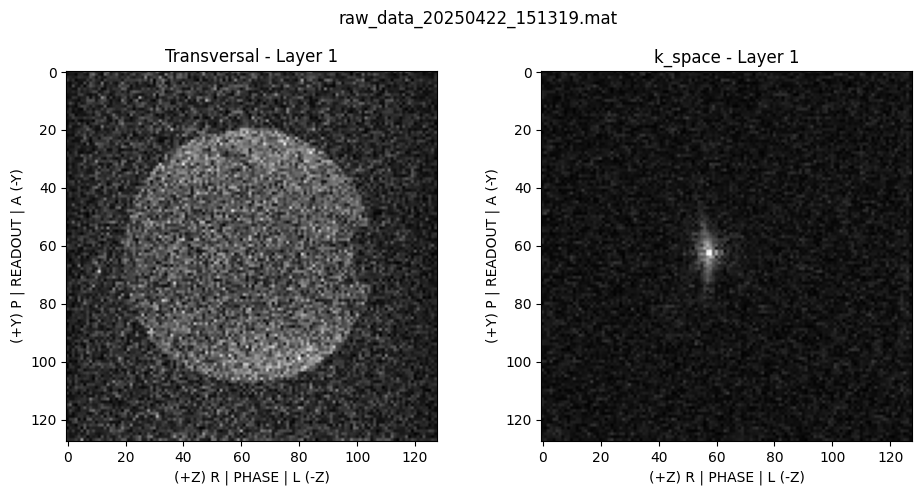

[{'widget': 'image',
  'data': array([[[ 8.84330959, 12.73442141, 14.30006268, ..., 19.09916539,
            6.01260791,  4.16507854],
          [ 5.98091315,  9.7739239 ,  9.85745799, ...,  6.4560774 ,
            4.92925206, 16.0906991 ],
          [16.80009193, 14.66686354, 11.37542485, ...,  8.6709754 ,
            5.43445665, 19.24206754],
          ...,
          [14.0461348 ,  7.74510591, 11.21684114, ..., 11.32442949,
           14.35665847,  4.26848194],
          [14.95438932,  7.57303674,  7.43889015, ...,  7.32970794,
            1.90683314,  8.13848876],
          [18.46687622, 16.36301653, 17.36004879, ..., 15.47646692,
           22.86609438, 18.92908833]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.97194188, -1.97448437, -1.97247192, ..., -1.93137593,
           -1.81589623, -1.90223248],
          [-1.86298328, -1.86642368, -1.94476405, .

In [ ]:
#RG2: -10dB #NOW

seq = SEMultislicePSEQ(
    nScans=1,
    larmorFreq=10.53436,
    rfExFA=90,
    rfReFA=180,
    rfSincExTime=3.0,
    rfSincReTime=3.0,
    repetitionTime=400.0,
    echoTime=15.0,
    fovInPlane=[100, 100],
    thickness=5,
    sliceGap=1,
    dfov=[0.0, 0.0, 12.0],
    nPoints=[128, 128, 1],
    axesOrientation=[1, 2, 0],
    bandwidth=21.33333333333333333333,
    shimming=[0.0013, 0.0013, 0.0005],
    phaseCycleEx=[0, 180],
    DephTime=1.25,
    sliceGradComp=0.5,
    sliceSpoilComp=0,
    sliceSpoilCompRD=1,
    phaseGradComp=0,
    riseTime=0.5,

)

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 0.0 min 51.2 seconds
Acquisition bandwidth fixed to: 21.333 kHz
delay_1: namespace(type='delay', delay=0.00375)
delay_2: namespace(type='delay', delay=0.00375)
delay_TR: namespace(type='delay', delay=0.377)
Creating batch_1.seq...
read 6 definitions, 1280 blocks, 2 shapes, 2 adc events, 3 rf events, 134 gradient shapes
batch_1.seq ready!
1 batches created with 16384 read points. Sequence ready!
Center frequecy set: 10.53356 MHz
Scan 1, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 1, batch 1/1 ready!
------------ max abs value: 0.12295177181773918
Moved: raw_data_20250422_151559 to experiments/acquisitions/2025.04.22


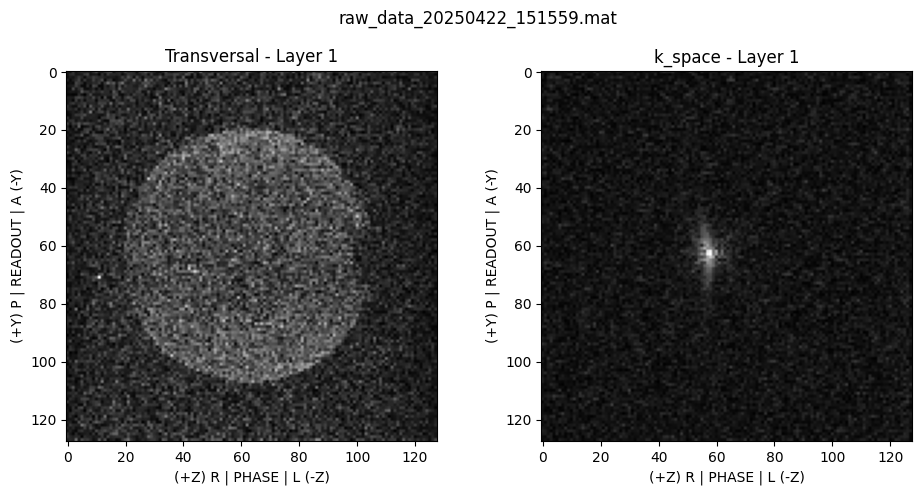

[{'widget': 'image',
  'data': array([[[10.47385379,  6.4503267 , 20.61497886, ..., 12.25002342,
           17.10458669, 14.9564562 ],
          [ 6.56838578, 16.03932344, 18.74002769, ...,  8.63460049,
            8.06345788,  2.87836555],
          [ 5.17309586, 10.44552807,  8.19545024, ...,  4.70391223,
            6.52680467, 17.42552565],
          ...,
          [20.30146944, 10.21915682,  2.5113322 , ..., 17.39951229,
           12.45557417,  8.02270357],
          [23.20427003, 15.14780749, 13.08385899, ...,  6.04910352,
           14.6186935 ,  8.25586471],
          [13.01238257, 16.56031585, 14.0953022 , ...,  4.7373206 ,
           15.71456325, 27.97207027]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.96391133, -1.92582181, -1.98159128, ..., -1.94587049,
           -1.82768315, -1.89848387],
          [-1.85651909, -1.99403763, -1.91404454, .

In [7]:
#RG2: -10dB #NOW

seq = SEMultislicePSEQ(
    nScans=1,
    larmorFreq=10.53356,
    rfExFA=90,
    rfReFA=180,
    rfSincExTime=3.0,
    rfSincReTime=3.0,
    repetitionTime=400.0,
    echoTime=15.0,
    fovInPlane=[100, 100],
    thickness=5,
    sliceGap=1,
    dfov=[0.0, 0.0, 12.0],
    nPoints=[128, 128, 1],
    axesOrientation=[1, 2, 0],
    bandwidth=21.33333333333333333333,
    shimming=[0.0013, 0.0013, 0.0005],
    phaseCycleEx=[0, 180],
    DephTime=1.25,
    sliceGradComp=0.5,
    sliceSpoilComp=0,
    sliceSpoilCompRD=1,
    phaseGradComp=0,
    riseTime=0.5,

)

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 7.0 min 40.799999999999955 seconds
Acquisition bandwidth fixed to: 21.333 kHz
delay_1: namespace(type='delay', delay=0.00375)
delay_2: namespace(type='delay', delay=0.00375)
delay_TR: namespace(type='delay', delay=0.27699999999999997)
Creating batch_1.seq...
read 6 definitions, 1280 blocks, 2 shapes, 2 adc events, 3 rf events, 134 gradient shapes
batch_1.seq ready!
1 batches created with 16384 read points. Sequence ready!
Center frequecy set: 10.533349999999999 MHz
Scan 1, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 1, batch 1/1 ready!
Scan 2, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 2, batch 1/1 ready!
Scan 3, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 3, batch 1/1 ready!
Scan 4, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 4, batch 1/1 ready!
Scan 5, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 5, batch 1/1 ready!

/home/lks/MaSeq_pack/marcos_client/server_comms.py:93: RuntimeWarning: SERVER ERROR: memory buffer underrun around byte address 0x100000
  warnings.warn("SERVER ERROR: " + k, RuntimeWarning)


Repeating batch...
Acquired points = 49152, Expected points = 49152
Scan 6, batch 1/1 ready!
Scan 7, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 7, batch 1/1 ready!
Scan 8, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 8, batch 1/1 ready!
Scan 9, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 9, batch 1/1 ready!
Scan 10, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 10, batch 1/1 ready!
Scan 11, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 11, batch 1/1 ready!
Scan 12, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 12, batch 1/1 ready!
------------ max abs value: 0.1302362220753973
Moved: raw_data_20250422_154356 to experiments/acquisitions/2025.04.22


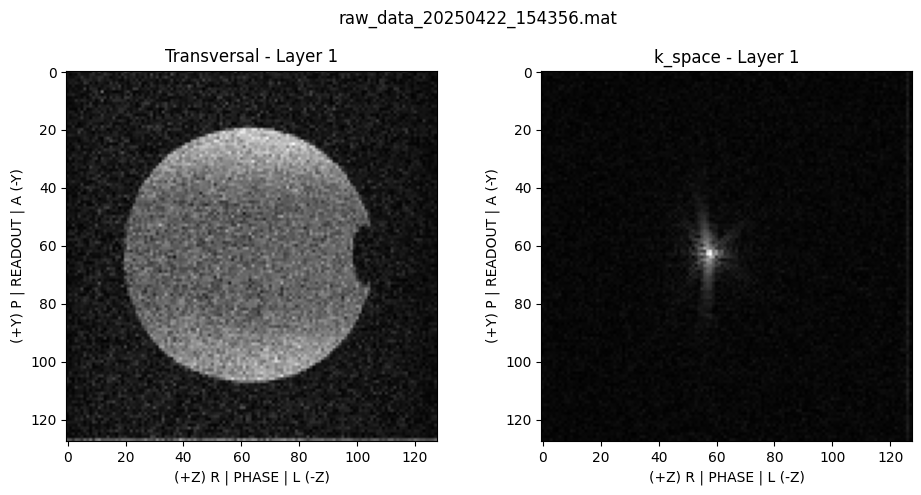

[{'widget': 'image',
  'data': array([[[ 4.12383783,  8.79476001, 10.48678227, ...,  4.52561429,
            5.0220305 ,  8.35873258],
          [ 8.96617102,  1.02654961,  5.2864024 , ...,  3.10658597,
            6.45994917,  7.57217343],
          [ 7.0765116 ,  5.29239739,  5.09795635, ...,  6.99707029,
            0.9393173 ,  4.06878722],
          ...,
          [ 2.81916823,  5.59162538, 12.50496214, ...,  4.05509215,
            8.38847381,  3.50520006],
          [ 5.99188072,  2.08982064,  3.11383538, ...,  2.42691918,
            3.26678703,  8.89785962],
          [35.23839135, 32.86444995, 20.45025418, ..., 29.59447219,
           31.51945283, 40.45811339]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.97067766, -1.94726496, -1.96746853, ..., -1.98452295,
           -1.91073083, -1.97483407],
          [-1.97523926, -1.94197897, -1.95714143, .

In [11]:
#RG2: -10dB #NOW

seq = SEMultislicePSEQ(
    nScans=12,
    larmorFreq=10.53335,
    rfExFA=90,
    rfReFA=180,
    rfSincExTime=3.0,
    rfSincReTime=3.0,
    repetitionTime=300.0,
    echoTime=15.0,
    fovInPlane=[100, 100],
    thickness=6,
    sliceGap=1,
    dfov=[0.0, 0.0, 12.0],
    nPoints=[128, 128, 1],
    axesOrientation=[1, 2, 0],
    bandwidth=21.33333333333333333333,
    shimming=[0.0013, 0.0013, 0.0005],
    phaseCycleEx=[0, 180],
    DephTime=1.25,
    sliceGradComp=0.5,
    sliceSpoilComp=0,
    sliceSpoilCompRD=1,
    phaseGradComp=0,
    riseTime=0.5,

)

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')


In [13]:
75.29411764705883/3


25.098039215686274

seq total time: 1.0 min 16.799999999999997 seconds
Acquisition bandwidth fixed to: 25.098 kHz
delay_1: namespace(type='delay', delay=0.00375)
delay_2: namespace(type='delay', delay=0.00375)
delay_TR: namespace(type='delay', delay=0.27745)
Creating batch_1.seq...
read 6 definitions, 1280 blocks, 2 shapes, 2 adc events, 3 rf events, 134 gradient shapes
batch_1.seq ready!
1 batches created with 16384 read points. Sequence ready!
Center frequecy set: 10.533349999999999 MHz
Scan 1, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 1, batch 1/1 ready!
Scan 2, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 2, batch 1/1 ready!
------------ max abs value: 0.012633004805474503
Moved: raw_data_20250422_162238 to experiments/acquisitions/2025.04.22


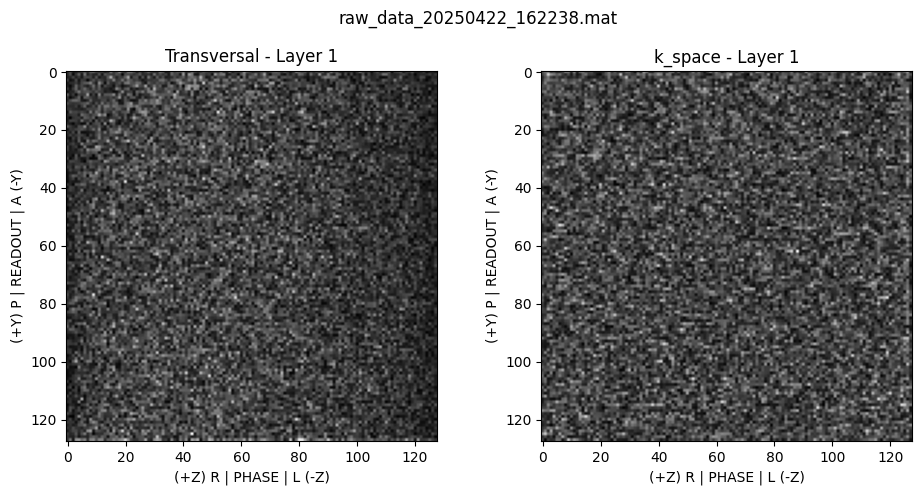

[{'widget': 'image',
  'data': array([[[16.71711093, 29.65645718, 12.24078555, ...,  9.29167563,
           11.09633301,  4.8297408 ],
          [15.69504493, 28.93345817,  3.42360913, ..., 24.57708268,
           13.59604967, 22.09796142],
          [13.0520452 , 14.84802073, 26.57614885, ...,  4.4902818 ,
           16.45604264, 13.57193864],
          ...,
          [25.69442713, 15.32789202, 18.26315163, ...,  5.80400244,
           30.44488803, 21.08176253],
          [20.44542512, 13.80049873, 12.65315523, ...,  7.0852784 ,
           16.60264109,  2.05520212],
          [20.77304904, 45.54193797,  8.17847222, ..., 39.39763741,
           25.51407415, 19.29701161]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.9101195 , -1.8761186 , -1.88607461, ..., -1.8807698 ,
           -1.83693641, -1.98700123],
          [-1.92976763, -1.89795342, -1.78102643, .

In [14]:
#RG2: -10dB #NOW

seq = SEMultislicePSEQ(
    nScans=2,
    larmorFreq=10.53335,
    rfExFA=90,
    rfReFA=180,
    rfSincExTime=3.0,
    rfSincReTime=3.0,
    repetitionTime=300.0,
    echoTime=15.0,
    fovInPlane=[100, 100],
    thickness=6,
    sliceGap=1,
    dfov=[0.0, 0.0, 12.0],
    nPoints=[128, 128, 1],
    axesOrientation=[1, 2, 0],
    bandwidth=25.098039215686274,
    shimming=[0.0013, 0.0013, 0.0005],
    phaseCycleEx=[0, 180],
    DephTime=1.25,
    sliceGradComp=0.5,
    sliceSpoilComp=0,
    sliceSpoilCompRD=1,
    phaseGradComp=0,
    riseTime=0.5,

)

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 0.0 min 51.2 seconds
Acquisition bandwidth fixed to: 21.333 kHz
delay_1: namespace(type='delay', delay=0.00375)
delay_2: namespace(type='delay', delay=0.00375)
delay_TR: namespace(type='delay', delay=0.377)
Creating batch_1.seq...
read 6 definitions, 1280 blocks, 2 shapes, 2 adc events, 3 rf events, 134 gradient shapes
batch_1.seq ready!
1 batches created with 16384 read points. Sequence ready!
Center frequecy set: 10.531979999999999 MHz
Scan 1, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 1, batch 1/1 ready!
------------ max abs value: 0.15594010253390264
Moved: raw_data_20250422_182728 to experiments/acquisitions/2025.04.22


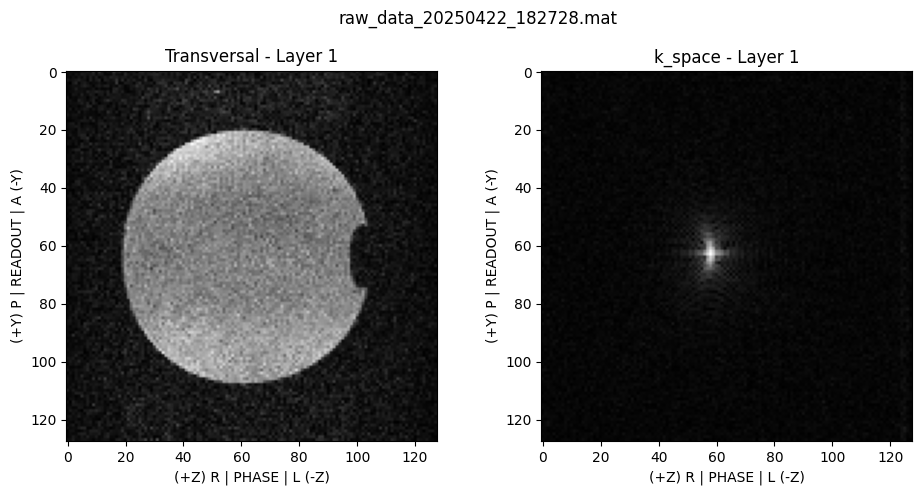

[{'widget': 'image',
  'data': array([[[ 6.99602465,  5.63830052,  5.90134633, ...,  3.34060173,
            3.37113307,  2.24671271],
          [ 3.29097119,  6.50188695,  3.27468251, ...,  4.47262084,
            6.79263895,  5.255183  ],
          [ 4.4527012 ,  2.47611511,  6.61704142, ...,  3.00800955,
            6.63806526,  5.40496466],
          ...,
          [ 2.04553   ,  5.1747253 ,  3.35307927, ...,  2.71554644,
            1.1127511 ,  4.02970626],
          [ 2.38762094,  4.19750771, 10.08837422, ...,  6.5804858 ,
            1.58794506,  1.0270511 ],
          [ 5.88803755,  6.03494639, 11.53364195, ...,  4.41332551,
            3.65807171,  2.36036564]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.95718062, -1.96032765, -1.98236786, ..., -1.95420251,
           -1.99730567, -1.98228148],
          [-1.981202  , -1.93176537, -1.958202  , .

In [15]:
#RG2: -10dB #NOW

seq = SEMultislicePSEQ(
    nScans=1,
    larmorFreq=10.53198,
    rfExFA=90,
    rfReFA=180,
    rfSincExTime=3.0,
    rfSincReTime=3.0,
    repetitionTime=400.0,
    echoTime=15.0,
    fovInPlane=[100, 100],
    thickness=5,
    sliceGap=1,
    dfov=[0.0, 0.0, 12.0],
    nPoints=[128, 128, 1],
    axesOrientation=[1, 2, 0],
    bandwidth=21.33333333333333333333,
    shimming=[0.0013, 0.0013, 0.0005],
    phaseCycleEx=[0, 180],
    DephTime=1.25,
    sliceGradComp=0.5,
    sliceSpoilComp=0,
    sliceSpoilCompRD=1,
    phaseGradComp=0,
    riseTime=0.5,

)

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 4.0 min 16.0 seconds
Acquisition bandwidth fixed to: 21.333 kHz
delay_1: namespace(type='delay', delay=0.00375)
delay_2: namespace(type='delay', delay=0.00375)
delay_TR: namespace(type='delay', delay=0.377)
Creating batch_1.seq...
read 6 definitions, 1280 blocks, 2 shapes, 2 adc events, 3 rf events, 134 gradient shapes
batch_1.seq ready!
1 batches created with 16384 read points. Sequence ready!
Center frequecy set: 10.531979999999999 MHz
Scan 1, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 1, batch 1/1 ready!
Scan 2, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 2, batch 1/1 ready!
Scan 3, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 3, batch 1/1 ready!
Scan 4, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 4, batch 1/1 ready!
Scan 5, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 5, batch 1/1 ready!
------------ max abs value:

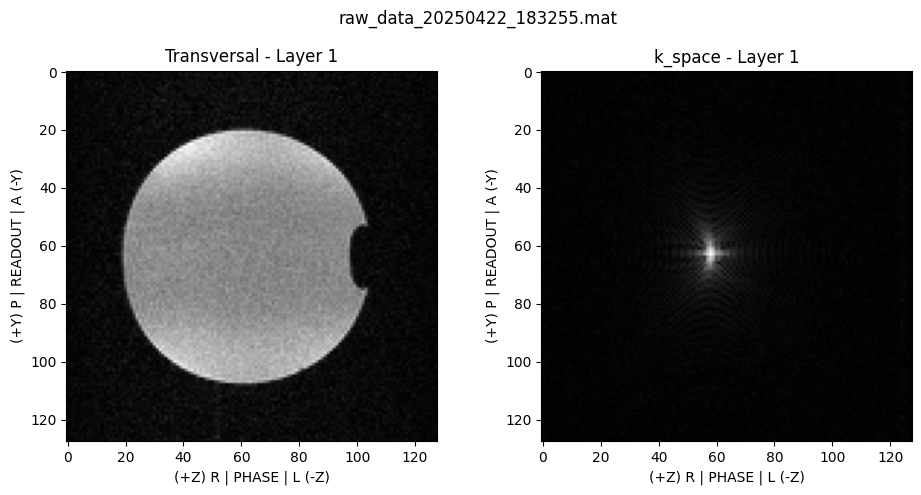

[{'widget': 'image',
  'data': array([[[4.99029599, 3.61932017, 2.51890829, ..., 1.09113842,
           5.46850755, 0.52232555],
          [1.84277324, 2.04638717, 2.93746315, ..., 2.1659113 ,
           3.76800028, 2.92358855],
          [1.1014075 , 5.44724656, 3.91293848, ..., 1.12310301,
           1.07599918, 1.06290301],
          ...,
          [1.21959386, 4.64923483, 5.60465745, ..., 2.84399731,
           4.0437673 , 2.84577327],
          [2.3403417 , 3.31792278, 1.33009499, ..., 1.97696957,
           1.39849972, 2.06089152],
          [0.93389521, 0.66195987, 2.04973237, ..., 3.19036282,
           2.14099067, 1.73817736]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.98356853, -1.98459152, -1.98363712, ..., -1.98163535,
           -1.98987444, -1.98479718],
          [-1.98434783, -1.98085036, -1.99520183, ..., -1.9740521 ,
           -1.98614

In [16]:
#RG2: -10dB #NOW

seq = SEMultislicePSEQ(
    nScans=5,
    larmorFreq=10.53198,
    rfExFA=90,
    rfReFA=180,
    rfSincExTime=3.0,
    rfSincReTime=3.0,
    repetitionTime=400.0,
    echoTime=15.0,
    fovInPlane=[100, 100],
    thickness=5,
    sliceGap=1,
    dfov=[0.0, 0.0, 12.0],
    nPoints=[128, 128, 1],
    axesOrientation=[1, 2, 0],
    bandwidth=21.33333333333333333333,
    shimming=[0.0013, 0.0013, 0.0005],
    phaseCycleEx=[0, 180],
    DephTime=1.25,
    sliceGradComp=0.5,
    sliceSpoilComp=0,
    sliceSpoilCompRD=1,
    phaseGradComp=0,
    riseTime=0.5,

)

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 7.0 min 40.799999999999955 seconds
Acquisition bandwidth fixed to: 21.333 kHz
delay_1: namespace(type='delay', delay=0.00375)
delay_2: namespace(type='delay', delay=0.00375)
delay_TR: namespace(type='delay', delay=0.27699999999999997)
Creating batch_1.seq...
read 6 definitions, 1280 blocks, 2 shapes, 2 adc events, 3 rf events, 134 gradient shapes
batch_1.seq ready!
1 batches created with 16384 read points. Sequence ready!
Center frequecy set: 10.531979999999999 MHz
Scan 1, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 1, batch 1/1 ready!
Scan 2, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 2, batch 1/1 ready!
Scan 3, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 3, batch 1/1 ready!
Scan 4, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 4, batch 1/1 ready!
Scan 5, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 5, batch 1/1 ready!

/home/lks/MaSeq_pack/marcos_client/server_comms.py:93: RuntimeWarning: SERVER ERROR: memory buffer underrun around byte address 0x80000
  warnings.warn("SERVER ERROR: " + k, RuntimeWarning)


Repeating batch...
Acquired points = 49152, Expected points = 49152
Scan 6, batch 1/1 ready!
Scan 7, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 7, batch 1/1 ready!
Scan 8, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 8, batch 1/1 ready!
Scan 9, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 9, batch 1/1 ready!
Scan 10, batch 1/1 running...


/home/lks/MaSeq_pack/marcos_client/server_comms.py:93: RuntimeWarning: SERVER ERROR: memory buffer underrun around byte address 0x40000
  warnings.warn("SERVER ERROR: " + k, RuntimeWarning)


Repeating batch...
Acquired points = 49152, Expected points = 49152
Scan 10, batch 1/1 ready!
Scan 11, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 11, batch 1/1 ready!
Scan 12, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 12, batch 1/1 ready!
------------ max abs value: 0.13965793237774077
Moved: raw_data_20250422_184302 to experiments/acquisitions/2025.04.22


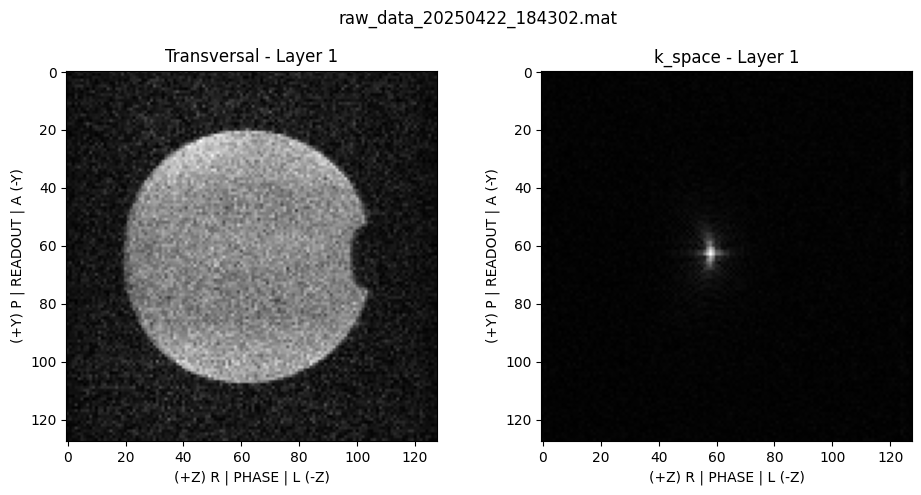

[{'widget': 'image',
  'data': array([[[ 2.67657785,  7.41950076,  2.44162782, ..., 10.27614685,
            4.95382116,  2.96069284],
          [ 2.75785325,  0.46890195,  7.15979996, ...,  5.94252804,
            6.82096954,  2.94357998],
          [ 6.27793042,  9.09751421,  2.88405806, ...,  4.58626583,
            7.35517819, 13.28267446],
          ...,
          [ 1.91422558,  2.4755518 ,  3.82651709, ...,  4.64086473,
            1.70593419,  3.85201967],
          [ 2.50655752,  3.45639389,  8.24374578, ..., 12.21477728,
            3.16364062,  6.44420265],
          [ 2.44205407,  5.80918992,  3.08861284, ...,  1.92459221,
            1.42215027,  1.99818769]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.99157279, -1.988354  , -1.9934582 , ..., -1.99370514,
           -1.98348421, -1.99910946],
          [-1.98973142, -1.99100508, -1.99421876, .

In [17]:
#RG2: -10dB #NOW

seq = SEMultislicePSEQ(
    nScans=12,
    larmorFreq=10.53198,
    rfExFA=90,
    rfReFA=180,
    rfSincExTime=3.0,
    rfSincReTime=3.0,
    repetitionTime=300.0,
    echoTime=15.0,
    fovInPlane=[100, 100],
    thickness=5,
    sliceGap=1,
    dfov=[0.0, 0.0, 12.0],
    nPoints=[128, 128, 1],
    axesOrientation=[1, 2, 0],
    bandwidth=21.33333333333333333333,
    shimming=[0.0013, 0.0013, 0.0005],
    phaseCycleEx=[0, 180],
    DephTime=1.25,
    sliceGradComp=0.5,
    sliceSpoilComp=0,
    sliceSpoilCompRD=1,
    phaseGradComp=0,
    riseTime=0.5,

)

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 3.0 min 12.0 seconds
Acquisition bandwidth fixed to: 21.333 kHz
delay_1: namespace(type='delay', delay=0.00375)
delay_2: namespace(type='delay', delay=0.00375)
delay_TR: namespace(type='delay', delay=0.27699999999999997)
Creating batch_1.seq...
read 6 definitions, 1280 blocks, 2 shapes, 2 adc events, 3 rf events, 134 gradient shapes
batch_1.seq ready!
1 batches created with 16384 read points. Sequence ready!
Center frequecy set: 10.531979999999999 MHz
Scan 1, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 1, batch 1/1 ready!
Scan 2, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 2, batch 1/1 ready!
Scan 3, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 3, batch 1/1 ready!
Scan 4, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 4, batch 1/1 ready!
Scan 5, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 5, batch 1/1 ready!
------------ 

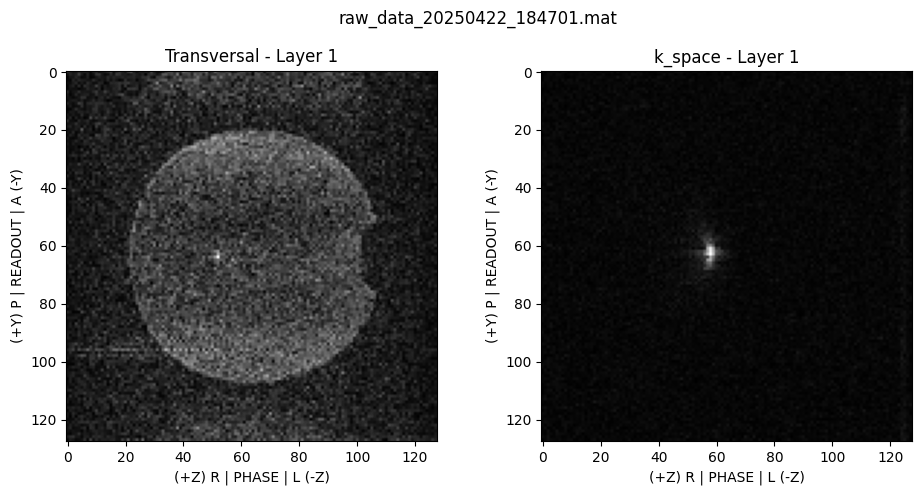

[{'widget': 'image',
  'data': array([[[19.90975529, 12.30958552,  7.99121908, ...,  7.2012344 ,
            7.38204711,  8.26729968],
          [ 5.73719966, 13.85175095,  9.99061303, ...,  7.05690851,
            6.05055271,  2.2519863 ],
          [ 1.18161784,  8.28109974,  8.46840974, ...,  6.75866766,
            2.73019842,  5.17128967],
          ...,
          [ 3.82985748,  2.15663447,  7.5374738 , ...,  6.89910233,
            4.40537695, 10.28847954],
          [11.18723611, 16.60156253, 19.2542549 , ...,  9.2656156 ,
            8.82704426, 11.42332404],
          [ 2.9356559 , 11.44562709,  8.90505146, ..., 10.32637609,
           21.16790003, 14.63878057]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.98204354, -1.99801616, -1.98904003, ..., -1.97672554,
           -1.9943894 , -1.99399937],
          [-1.99589118, -1.99209677, -1.97892677, .

In [ ]:
#RG2: -10dB #NOW

seq = SEMultislicePSEQ(
    nScans=5,
    larmorFreq=10.53255,
    rfExFA=90,
    rfReFA=180,
    rfSincExTime=3.0,
    rfSincReTime=3.0,
    repetitionTime=300.0,
    echoTime=15.0,
    fovInPlane=[100, 100],
    thickness=5,
    sliceGap=1,
    dfov=[0.0, 0.0, 12.0],
    nPoints=[128, 128, 1],
    axesOrientation=[1, 2, 0],
    bandwidth=21.33333333333333333333,
    shimming=[0.0013, 0.0013, 0.0005],
    phaseCycleEx=[0, 180],
    DephTime=1.25,
    sliceGradComp=0.5,
    sliceSpoilComp=0,
    sliceSpoilCompRD=1,
    phaseGradComp=0,
    riseTime=0.5,

)

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 3.0 min 12.0 seconds
Acquisition bandwidth fixed to: 21.333 kHz
delay_1: namespace(type='delay', delay=0.00375)
delay_2: namespace(type='delay', delay=0.00375)
delay_TR: namespace(type='delay', delay=0.27699999999999997)
Creating batch_1.seq...
read 6 definitions, 1280 blocks, 2 shapes, 2 adc events, 3 rf events, 134 gradient shapes
batch_1.seq ready!
1 batches created with 16384 read points. Sequence ready!
Center frequecy set: 10.532549999999999 MHz
Scan 1, batch 1/1 running...
Repeating batch...
Acquired points = 49152, Expected points = 49152
Scan 1, batch 1/1 ready!
Scan 2, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 2, batch 1/1 ready!
Scan 3, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 3, batch 1/1 ready!
Scan 4, batch 1/1 running...
Repeating batch...
Acquired points = 49152, Expected points = 49152
Scan 4, batch 1/1 ready!
Scan 5, batch 1/1 running...
Acquired points = 49152, Expected points = 49152


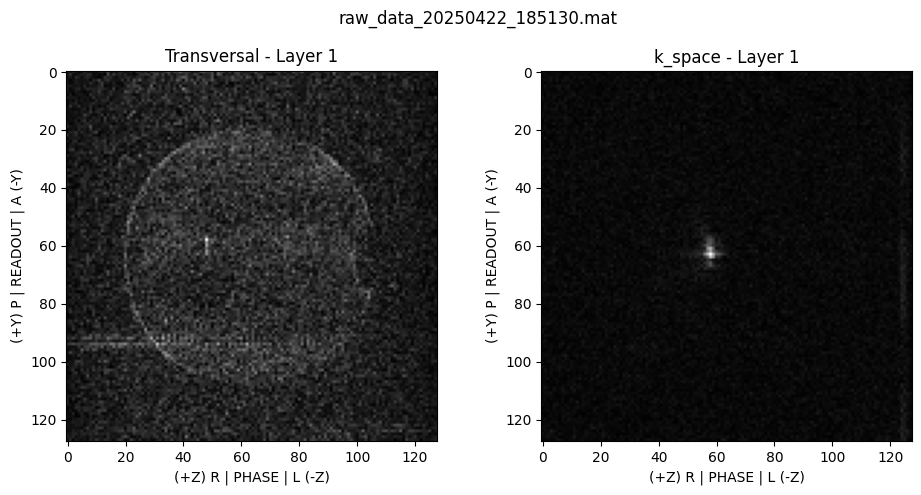

[{'widget': 'image',
  'data': array([[[ 9.81733954,  5.47407719, 16.85437551, ...,  5.1861485 ,
           10.60427537,  2.93108568],
          [ 8.21731211, 20.50125015,  4.7990234 , ...,  8.89509511,
            8.88137433,  5.78096765],
          [ 6.04279091, 10.4137386 ,  3.99568764, ...,  9.27017519,
            4.27185484,  4.77639768],
          ...,
          [ 9.92508698,  8.36501221, 14.02481377, ...,  2.46867338,
            6.13731312,  3.23666574],
          [12.95926449,  9.22381877, 15.79587602, ...,  4.79546703,
            8.79974833, 11.62691474],
          [ 6.48393937, 16.21026673,  3.09443581, ...,  8.04091727,
           11.07935956, 13.10721981]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.96884885, -1.98597256, -1.98910369, ..., -1.98629106,
           -1.99755803, -1.97603186],
          [-1.99074669, -1.98139383, -1.99221803, .

In [19]:
#RG2: -10dB #NOW

seq = SEMultislicePSEQ(
    nScans=5,
    larmorFreq=10.53255,
    rfExFA=90,
    rfReFA=180,
    rfSincExTime=3.0,
    rfSincReTime=3.0,
    repetitionTime=300.0,
    echoTime=15.0,
    fovInPlane=[100, 100],
    thickness=5,
    sliceGap=1,
    dfov=[0.0, 0.0, 12.0],
    nPoints=[128, 128, 1],
    axesOrientation=[1, 2, 0],
    bandwidth=21.33333333333333333333,
    shimming=[0.0013, 0.0013, 0.0005],
    phaseCycleEx=[0, 180],
    DephTime=1.25,
    sliceGradComp=0.5,
    sliceSpoilComp=0,
    sliceSpoilCompRD=1,
    phaseGradComp=0,
    riseTime=0.5,

)

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 0.0 min 51.2 seconds
Acquisition bandwidth fixed to: 21.333 kHz
delay_1: namespace(type='delay', delay=0.00375)
delay_2: namespace(type='delay', delay=0.00375)
delay_TR: namespace(type='delay', delay=0.377)
Creating batch_1.seq...
read 6 definitions, 1280 blocks, 2 shapes, 2 adc events, 3 rf events, 134 gradient shapes
batch_1.seq ready!
1 batches created with 16384 read points. Sequence ready!
Center frequecy set: 10.53281 MHz
Scan 1, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 1, batch 1/1 ready!
------------ max abs value: 0.16884319546244095
Moved: raw_data_20250422_185322 to experiments/acquisitions/2025.04.22


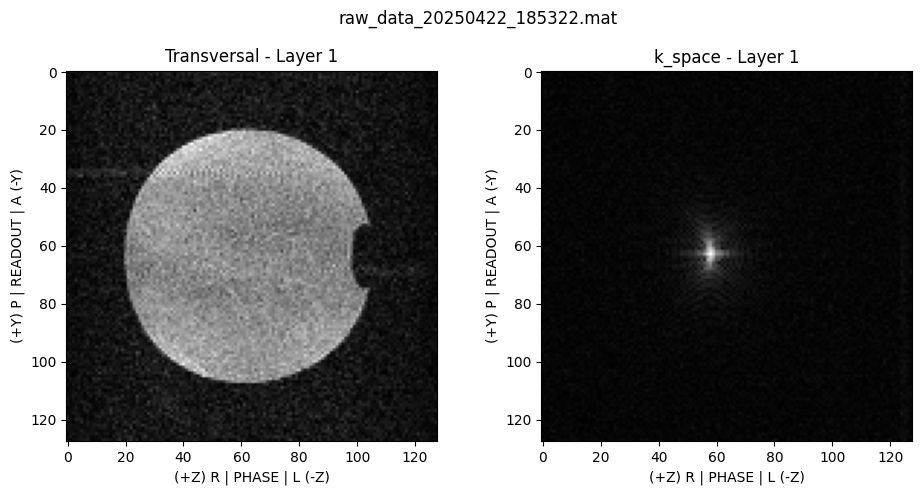

[{'widget': 'image',
  'data': array([[[ 0.56942019,  5.306707  , 12.88758738, ...,  0.23173361,
            2.29125191,  5.14250962],
          [ 5.24150032,  2.91374037,  0.34995679, ...,  1.4207954 ,
            6.23627252,  2.66484051],
          [ 6.18720745,  2.40026082,  1.3007023 , ...,  5.43263282,
            1.18908886,  3.72216876],
          ...,
          [ 2.93596993,  6.48215199,  9.77771538, ...,  6.70851521,
            5.79806057,  5.08012279],
          [ 4.01500988,  8.98668499,  4.12157909, ...,  5.84465048,
            2.11126206,  3.29089476],
          [ 7.76961457,  1.23593481,  6.14497083, ...,  4.87103453,
            4.03545662,  5.16132463]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.9417765 , -1.98406002, -1.97550268, ..., -1.95375993,
           -1.99041947, -1.98459755],
          [-1.97781628, -1.95186208, -1.97985345, .

In [20]:
#RG2: -10dB #NOW

seq = SEMultislicePSEQ(
    nScans=1,
    larmorFreq=10.53281,
    rfExFA=90,
    rfReFA=180,
    rfSincExTime=3.0,
    rfSincReTime=3.0,
    repetitionTime=400.0,
    echoTime=15.0,
    fovInPlane=[100, 100],
    thickness=5,
    sliceGap=1,
    dfov=[0.0, 0.0, 12.0],
    nPoints=[128, 128, 1],
    axesOrientation=[1, 2, 0],
    bandwidth=21.33333333333333333333,
    shimming=[0.0013, 0.0013, 0.0005],
    phaseCycleEx=[0, 180],
    DephTime=1.25,
    sliceGradComp=0.5,
    sliceSpoilComp=0,
    sliceSpoilCompRD=1,
    phaseGradComp=0,
    riseTime=0.5,

)

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 2.0 min 33.60000000000002 seconds
Acquisition bandwidth fixed to: 21.333 kHz
delay_1: namespace(type='delay', delay=0.00375)
delay_2: namespace(type='delay', delay=0.00375)
delay_TR: namespace(type='delay', delay=0.377)
Creating batch_1.seq...
read 6 definitions, 1280 blocks, 2 shapes, 2 adc events, 3 rf events, 134 gradient shapes
batch_1.seq ready!
1 batches created with 16384 read points. Sequence ready!
Center frequecy set: 10.53281 MHz
Scan 1, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 1, batch 1/1 ready!
Scan 2, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 2, batch 1/1 ready!
Scan 3, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 3, batch 1/1 ready!
------------ max abs value: 0.17527564896716516
Moved: raw_data_20250422_185703 to experiments/acquisitions/2025.04.22


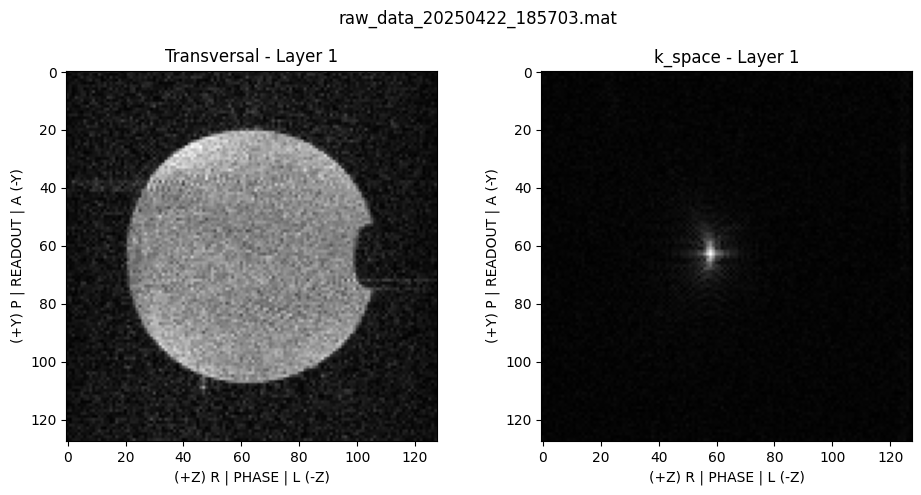

[{'widget': 'image',
  'data': array([[[ 1.9521978 , 12.48435932,  5.37698995, ...,  2.33609349,
            8.82927251,  3.64106806],
          [ 1.99471003,  2.74202539,  8.4166014 , ...,  7.31194477,
            2.28192646,  5.93979691],
          [ 5.16204994,  7.62270327,  3.10379831, ...,  4.14569745,
            3.15585633,  3.03697043],
          ...,
          [ 9.24746065,  3.30275364,  6.6422573 , ...,  6.30126731,
            3.19256927,  6.25667622],
          [ 2.57969158, 10.2941216 ,  1.82561329, ...,  9.32824634,
            3.96103668,  7.1048405 ],
          [ 2.15299355,  4.65680546,  9.17672197, ...,  4.73555077,
            1.97569118, 10.71305803]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.99353006, -1.99191097, -1.9927802 , ..., -1.95264289,
           -1.98940732, -1.98043606],
          [-1.9689986 , -1.99412015, -1.98465176, .

In [21]:
#RG2: -10dB #NOW

seq = SEMultislicePSEQ(
    nScans=3,
    larmorFreq=10.53281,
    rfExFA=90,
    rfReFA=180,
    rfSincExTime=3.0,
    rfSincReTime=3.0,
    repetitionTime=400.0,
    echoTime=15.0,
    fovInPlane=[100, 100],
    thickness=5,
    sliceGap=1,
    dfov=[0.0, 0.0, 12.0],
    nPoints=[128, 128, 1],
    axesOrientation=[1, 2, 0],
    bandwidth=21.33333333333333333333,
    shimming=[0.0013, 0.0013, 0.0005],
    phaseCycleEx=[0, 180],
    DephTime=1.25,
    sliceGradComp=0.5,
    sliceSpoilComp=0,
    sliceSpoilCompRD=1,
    phaseGradComp=0,
    riseTime=0.5,

)

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 1.0 min 42.400000000000006 seconds
Acquisition bandwidth fixed to: 21.333 kHz
delay_1: namespace(type='delay', delay=0.0062499999999999995)
delay_2: namespace(type='delay', delay=0.0062499999999999995)
delay_TR: namespace(type='delay', delay=0.369)
Creating batch_1.seq...
read 6 definitions, 2560 blocks, 2 shapes, 2 adc events, 3 rf events, 262 gradient shapes
batch_1.seq ready!
1 batches created with 65536 read points. Sequence ready!
Center frequecy set: 10.53379 MHz
Scan 1, batch 1/1 running...
Acquired points = 196608, Expected points = 196608
Scan 1, batch 1/1 ready!
------------ max abs value: 0.1793888162460875
Moved: raw_data_20250422_191723 to experiments/acquisitions/2025.04.22


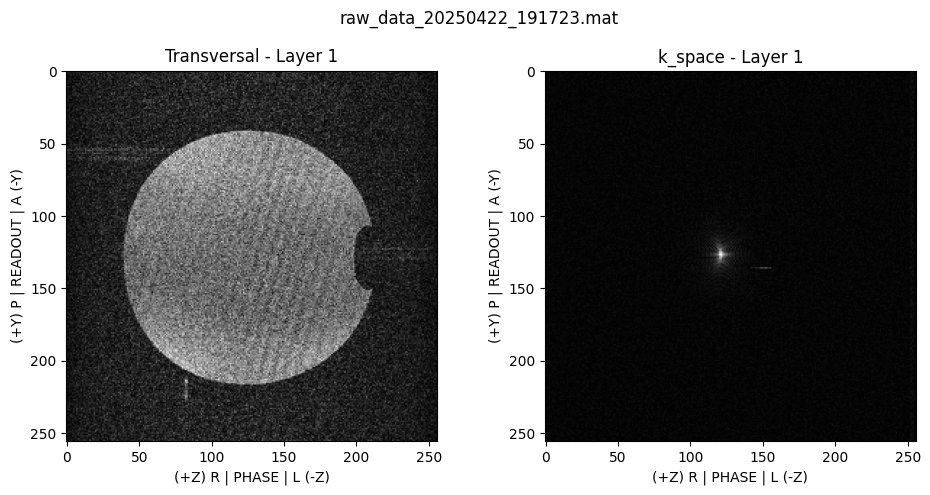

[{'widget': 'image',
  'data': array([[[ 5.00989115,  5.64284349,  5.20821284, ...,  3.67654052,
            7.17149789, 11.32529582],
          [ 6.78164369,  9.12405044, 13.90895803, ...,  6.77942273,
           15.72147704,  3.55988727],
          [ 9.82764551, 11.85590707,  8.71474789, ...,  5.03538185,
            2.07015356,  3.93158163],
          ...,
          [11.52155262,  5.76966884,  7.18493207, ...,  4.76386478,
            4.84702687,  7.76040704],
          [ 2.25542964,  9.82540503,  6.2722568 , ...,  9.58578467,
            5.85020241,  4.53838207],
          [ 6.43101192,  1.69339076, 12.02064004, ...,  6.89840804,
            7.24584765,  0.52565405]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.99533887, -1.98371961, -1.98876561, ..., -1.91155793,
           -1.97364875, -1.98176041],
          [-1.96982574, -1.97195291, -1.98559923, .

In [24]:
#RG2: -10dB #NOW

seq = SEMultislicePSEQ(
    nScans=1,
    larmorFreq=10.53379,
    rfExFA=90,
    rfReFA=180,
    rfSincExTime=3.0,
    rfSincReTime=3.0,
    repetitionTime=400.0,
    echoTime=20.0,
    fovInPlane=[100, 100],
    thickness=5,
    sliceGap=1,
    dfov=[0.0, 0.0, 12.0],
    nPoints=[256, 256, 1],
    axesOrientation=[1, 2, 0],
    bandwidth=21.33333333333333333333,
    shimming=[0.0013, 0.0013, 0.0005],
    phaseCycleEx=[0, 180],
    DephTime=1.25,
    sliceGradComp=0.5,
    sliceSpoilComp=0,
    sliceSpoilCompRD=1,
    phaseGradComp=0,
    riseTime=0.5,

)

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 1.0 min 16.799999999999997 seconds
Acquisition bandwidth fixed to: 21.333 kHz
delay_1: namespace(type='delay', delay=0.0062499999999999995)
delay_2: namespace(type='delay', delay=0.0062499999999999995)
delay_TR: namespace(type='delay', delay=0.26899999999999996)
Creating batch_1.seq...
read 6 definitions, 2560 blocks, 2 shapes, 2 adc events, 3 rf events, 262 gradient shapes
batch_1.seq ready!
1 batches created with 65536 read points. Sequence ready!
Center frequecy set: 10.5339 MHz
Scan 1, batch 1/1 running...
Acquired points = 196608, Expected points = 196608
Scan 1, batch 1/1 ready!
------------ max abs value: 0.13851622599634905
Moved: raw_data_20250422_192249 to experiments/acquisitions/2025.04.22


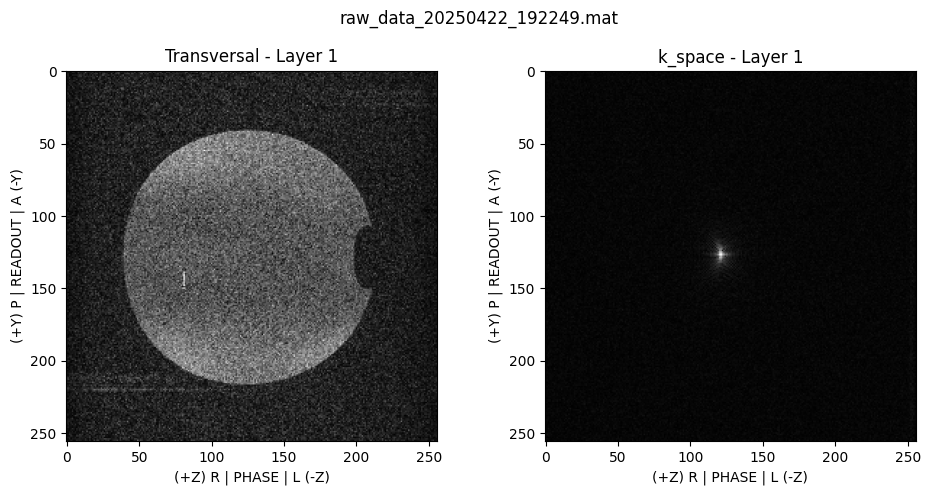

[{'widget': 'image',
  'data': array([[[ 9.50869338,  8.23060128,  0.75291116, ...,  6.90816788,
           11.92376926,  4.24561546],
          [ 7.62906552,  4.76394455,  3.90266087, ...,  7.3844475 ,
            3.74417333, 14.05042141],
          [ 4.76020042, 12.43286662,  3.03747721, ...,  6.24734149,
            1.49469894,  5.95688874],
          ...,
          [ 6.76954528, 11.18319531, 12.6149199 , ...,  1.47268177,
            0.9813906 ,  8.83061861],
          [ 5.11311512,  5.13917964, 15.08292599, ...,  3.26560801,
            4.67046775,  3.69471975],
          [ 2.64564046,  4.7732474 ,  4.41850674, ..., 20.36867042,
            4.71317894,  7.14204074]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.96109812, -1.9951148 , -1.97301069, ..., -1.94998407,
           -1.94085954, -1.9943101 ],
          [-1.96725401, -1.96044772, -1.97613817, .

In [ ]:
#RG2: -10dB #NOW

seq = SEMultislicePSEQ(
    nScans=1,
    larmorFreq=10.53396,
    rfExFA=90,
    rfReFA=180,
    rfSincExTime=3.0,
    rfSincReTime=3.0,
    repetitionTime=300.0,
    echoTime=20.0,
    fovInPlane=[100, 100],
    thickness=5,
    sliceGap=1,
    dfov=[0.0, 0.0, 12.0],
    nPoints=[256, 256, 1],
    axesOrientation=[1, 2, 0],
    bandwidth=21.33333333333333333333,
    shimming=[0.0013, 0.0013, 0.0005],
    phaseCycleEx=[0, 180],
    DephTime=1.25,
    sliceGradComp=0.5,
    sliceSpoilComp=0,
    sliceSpoilCompRD=1,
    phaseGradComp=0,
    riseTime=0.5,

)

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 1.0 min 16.799999999999997 seconds
Acquisition bandwidth fixed to: 21.333 kHz
delay_1: namespace(type='delay', delay=0.0062499999999999995)
delay_2: namespace(type='delay', delay=0.0062499999999999995)
delay_TR: namespace(type='delay', delay=0.26899999999999996)
Creating batch_1.seq...
read 6 definitions, 2560 blocks, 2 shapes, 2 adc events, 3 rf events, 262 gradient shapes
batch_1.seq ready!
1 batches created with 65536 read points. Sequence ready!
Center frequecy set: 10.534139999999999 MHz
Scan 1, batch 1/1 running...
Acquired points = 196608, Expected points = 196608
Scan 1, batch 1/1 ready!
------------ max abs value: 0.1365142024329784
Moved: raw_data_20250422_193404 to experiments/acquisitions/2025.04.22


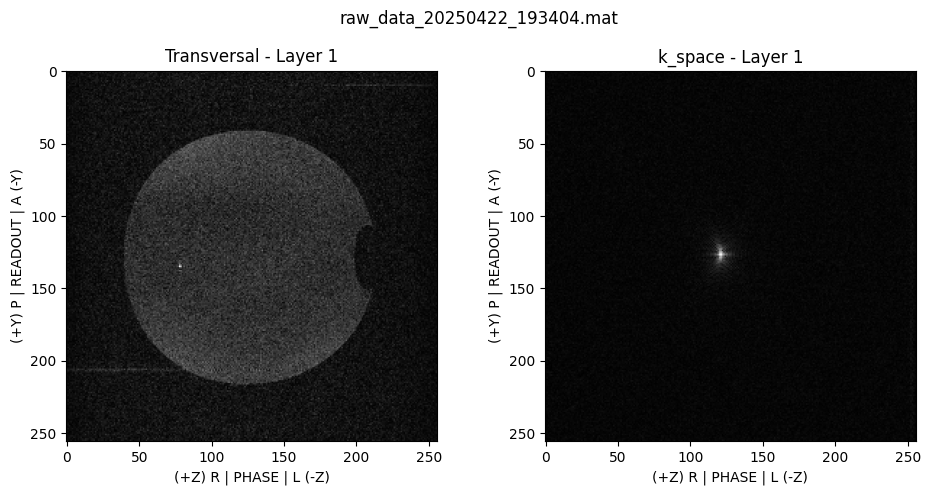

[{'widget': 'image',
  'data': array([[[5.83534341, 4.54707294, 9.02209323, ..., 5.37946308,
           1.62657372, 1.40833793],
          [3.43807699, 4.01819534, 1.9606322 , ..., 3.36778451,
           7.17652398, 5.39426084],
          [1.8529475 , 8.22006072, 2.0794489 , ..., 5.69907118,
           3.64574865, 1.46013068],
          ...,
          [3.62736467, 5.44689198, 8.08442538, ..., 1.32009046,
           3.71664477, 4.85361852],
          [4.60277064, 4.42720729, 6.05995168, ..., 3.78935001,
           6.16363928, 2.89074122],
          [5.25973306, 4.80357703, 2.23642128, ..., 3.58416562,
           4.11751026, 6.83945546]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.97494247, -1.99009881, -1.9633103 , ..., -1.98874711,
           -1.95198376, -1.95562461],
          [-1.95781971, -1.96483166, -1.96935304, ..., -1.99212079,
           -1.95317

In [ ]:
#RG2: -10dB #NOW

seq = SEMultislicePSEQ(
    nScans=1,
    larmorFreq=10.53420,
    rfExFA=90,
    rfReFA=180,
    rfSincExTime=3.0,
    rfSincReTime=3.0,
    repetitionTime=300.0,
    echoTime=20.0,
    fovInPlane=[100, 100],
    thickness=5,
    sliceGap=1,
    dfov=[0.0, 0.0, 12.0],
    nPoints=[256, 256, 1],
    axesOrientation=[1, 2, 0],
    bandwidth=21.33333333333333333333,
    shimming=[0.0013, 0.0013, 0.0005],
    phaseCycleEx=[0, 180],
    DephTime=1.25,
    sliceGradComp=0.5,
    sliceSpoilComp=0,
    sliceSpoilCompRD=1,
    phaseGradComp=0,
    riseTime=0.5,

)

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 1.0 min 16.799999999999997 seconds
Acquisition bandwidth fixed to: 21.333 kHz
delay_1: namespace(type='delay', delay=0.0062499999999999995)
delay_2: namespace(type='delay', delay=0.0062499999999999995)
delay_TR: namespace(type='delay', delay=0.26899999999999996)
Creating batch_1.seq...
read 6 definitions, 2560 blocks, 2 shapes, 2 adc events, 3 rf events, 262 gradient shapes
batch_1.seq ready!
1 batches created with 65536 read points. Sequence ready!
Center frequecy set: 10.5342 MHz
Scan 1, batch 1/1 running...
Acquired points = 196608, Expected points = 196608
Scan 1, batch 1/1 ready!
------------ max abs value: 0.16999028097293079
Moved: raw_data_20250422_193614 to experiments/acquisitions/2025.04.22


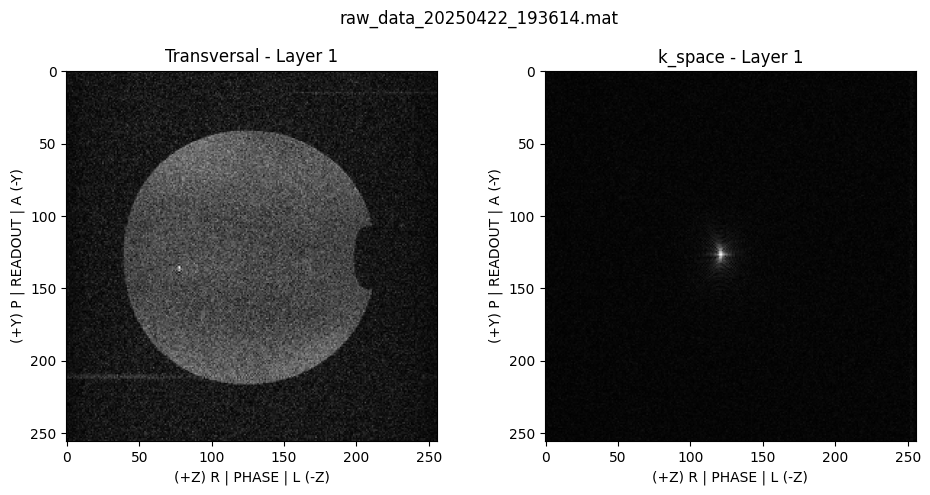

[{'widget': 'image',
  'data': array([[[ 3.84921735, 10.70826084,  7.04524375, ...,  5.77084095,
            5.21511081,  5.72209782],
          [ 2.46639843,  2.79662109,  4.08321922, ...,  3.65211682,
            8.51334799,  5.8860504 ],
          [ 4.23740744,  9.6791242 , 14.46096978, ...,  4.74448771,
            2.92861798,  4.40833573],
          ...,
          [16.4369696 ,  5.5024043 ,  4.25888026, ...,  2.55425648,
            6.06115491,  3.7113269 ],
          [ 3.70812405,  0.81988413,  7.71014654, ...,  7.69820924,
            8.0312827 ,  1.50046654],
          [ 1.73151696,  4.0841806 , 12.26293572, ...,  1.45136229,
           12.15068232,  6.9307178 ]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.9923278 , -1.9857923 , -1.95037925, ..., -1.98511915,
           -1.97558291, -1.99373604],
          [-1.95470262, -1.97361255, -1.98727502, .

In [29]:
#RG2: -10dB #NOW

seq = SEMultislicePSEQ(
    nScans=1,
    larmorFreq=10.53420,
    rfExFA=90,
    rfReFA=180,
    rfSincExTime=3.0,
    rfSincReTime=3.0,
    repetitionTime=300.0,
    echoTime=20.0,
    fovInPlane=[100, 100],
    thickness=6,
    sliceGap=1,
    dfov=[0.0, 0.0, 12.0],
    nPoints=[256, 256, 1],
    axesOrientation=[1, 2, 0],
    bandwidth=21.33333333333333333333,
    shimming=[0.0013, 0.0013, 0.0005],
    phaseCycleEx=[0, 180],
    DephTime=1.25,
    sliceGradComp=0.5,
    sliceSpoilComp=0,
    sliceSpoilCompRD=1,
    phaseGradComp=0,
    riseTime=0.5,

)

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 1.0 min 16.799999999999997 seconds
Acquisition bandwidth fixed to: 21.333 kHz
delay_1: namespace(type='delay', delay=0.0062499999999999995)
delay_2: namespace(type='delay', delay=0.0062499999999999995)
delay_TR: namespace(type='delay', delay=0.26899999999999996)
Creating batch_1.seq...
read 6 definitions, 2560 blocks, 2 shapes, 2 adc events, 3 rf events, 262 gradient shapes
batch_1.seq ready!
1 batches created with 65536 read points. Sequence ready!
Center frequecy set: 10.5342 MHz
Scan 1, batch 1/1 running...
Acquired points = 196608, Expected points = 196608
Scan 1, batch 1/1 ready!
------------ max abs value: 0.18830969837477107
Moved: raw_data_20250422_193809 to experiments/acquisitions/2025.04.22


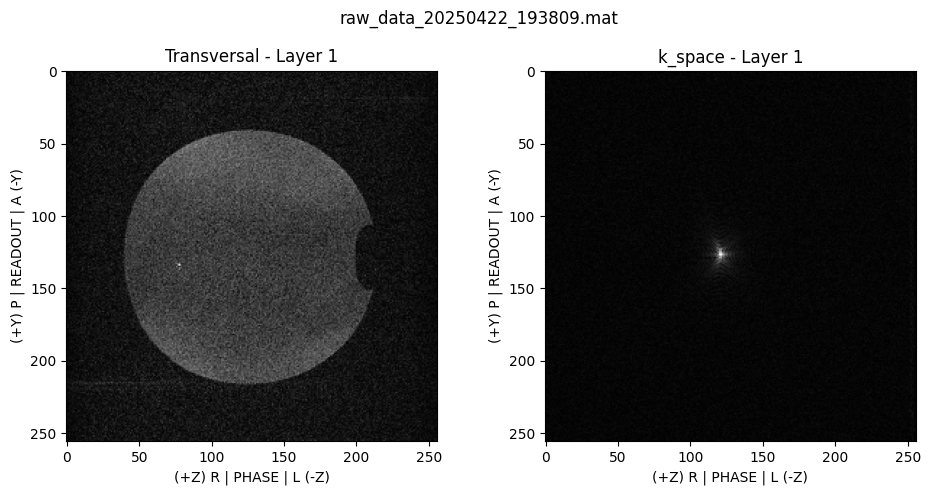

[{'widget': 'image',
  'data': array([[[0.3307957 , 3.93899175, 4.63127927, ..., 5.81741164,
           4.36113362, 6.117901  ],
          [4.43166973, 2.47087951, 1.01008988, ..., 5.86612174,
           2.85871129, 2.8091193 ],
          [5.11760002, 1.13651848, 4.26371709, ..., 3.27354487,
           6.01211307, 4.63609065],
          ...,
          [2.16374152, 4.33605371, 1.97202646, ..., 2.18679455,
           7.88850622, 1.88196827],
          [5.90910336, 4.23006682, 2.41931176, ..., 4.90609182,
           7.35188943, 7.30102801],
          [1.74257598, 0.8514992 , 2.74750069, ..., 1.83441601,
           6.96935987, 3.30938014]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.98557732, -1.96223052, -1.99403107, ..., -1.93340227,
           -1.963361  , -1.98058516],
          [-1.98118995, -1.9781436 , -1.96202031, ..., -1.96027657,
           -1.99516

In [30]:
#RG2: -10dB #NOW

seq = SEMultislicePSEQ(
    nScans=1,
    larmorFreq=10.53420,
    rfExFA=90,
    rfReFA=180,
    rfSincExTime=3.0,
    rfSincReTime=3.0,
    repetitionTime=300.0,
    echoTime=20.0,
    fovInPlane=[100, 100],
    thickness=6,
    sliceGap=1,
    dfov=[0.0, 0.0, 8.0],
    nPoints=[256, 256, 1],
    axesOrientation=[1, 2, 0],
    bandwidth=21.33333333333333333333,
    shimming=[0.0013, 0.0013, 0.0005],
    phaseCycleEx=[0, 180],
    DephTime=1.25,
    sliceGradComp=0.5,
    sliceSpoilComp=0,
    sliceSpoilCompRD=1,
    phaseGradComp=0,
    riseTime=0.5,

)

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 3.0 min 50.39999999999998 seconds
Acquisition bandwidth fixed to: 21.333 kHz
delay_1: namespace(type='delay', delay=0.0062499999999999995)
delay_2: namespace(type='delay', delay=0.0062499999999999995)
delay_TR: namespace(type='delay', delay=0.26899999999999996)
Creating batch_1.seq...
read 6 definitions, 2560 blocks, 2 shapes, 2 adc events, 3 rf events, 262 gradient shapes
batch_1.seq ready!
1 batches created with 65536 read points. Sequence ready!
Center frequecy set: 10.5342 MHz
Scan 1, batch 1/1 running...
Repeating batch...
Acquired points = 196608, Expected points = 196608
Scan 1, batch 1/1 ready!
Scan 2, batch 1/1 running...


/home/lks/MaSeq_pack/marcos_client/server_comms.py:93: RuntimeWarning: SERVER ERROR: memory buffer underrun around byte address 0x1c0000
  warnings.warn("SERVER ERROR: " + k, RuntimeWarning)


Repeating batch...
Acquired points = 196608, Expected points = 196608
Scan 2, batch 1/1 ready!
Scan 3, batch 1/1 running...
Acquired points = 196608, Expected points = 196608
Scan 3, batch 1/1 ready!
------------ max abs value: 0.19624485512120787
Moved: raw_data_20250422_194339 to experiments/acquisitions/2025.04.22


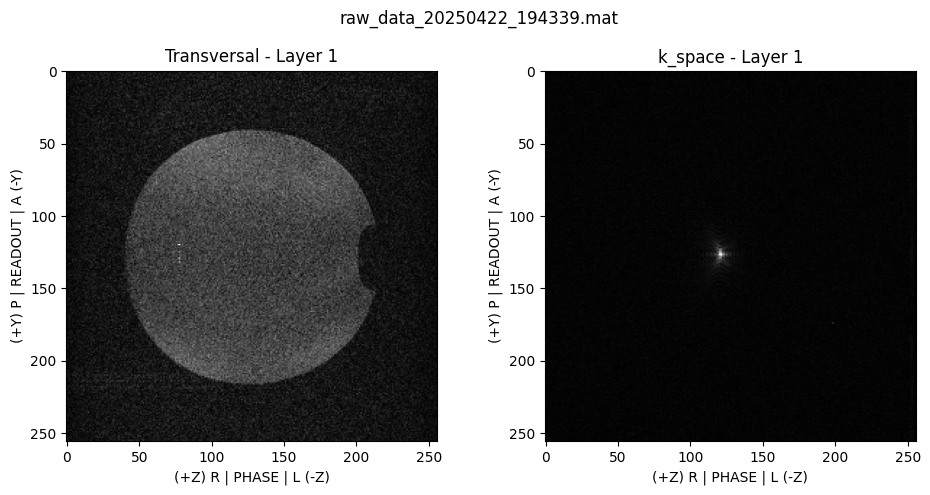

[{'widget': 'image',
  'data': array([[[ 3.50735885,  4.79217931,  3.99286426, ...,  2.47783439,
            3.38743316,  3.22521899],
          [ 3.29349967,  6.08709774,  5.86334003, ..., 10.96339219,
            4.32660043,  4.90465762],
          [13.35326049,  4.94920076,  3.03868736, ...,  3.89890365,
            1.5160467 ,  2.20520763],
          ...,
          [10.11394767,  8.05197263, 11.65082372, ...,  5.66697575,
            7.65048963,  5.59113691],
          [ 4.95498827, 10.96308546,  1.41778729, ...,  3.86833247,
            6.66798367,  4.32288389],
          [ 4.31361833, 10.11713036,  2.57824872, ...,  5.39726199,
            4.71862398,  2.77409402]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.99337524, -1.97866865, -1.99796995, ..., -1.99043926,
           -1.9769889 , -1.98667186],
          [-1.98915185, -1.97999583, -1.99140857, .

In [31]:
#RG2: -10dB #NOW

seq = SEMultislicePSEQ(
    nScans=3,
    larmorFreq=10.53420,
    rfExFA=90,
    rfReFA=180,
    rfSincExTime=3.0,
    rfSincReTime=3.0,
    repetitionTime=300.0,
    echoTime=20.0,
    fovInPlane=[100, 100],
    thickness=6,
    sliceGap=1,
    dfov=[0.0, 0.0, 8.0],
    nPoints=[256, 256, 1],
    axesOrientation=[1, 2, 0],
    bandwidth=21.33333333333333333333,
    shimming=[0.0013, 0.0013, 0.0005],
    phaseCycleEx=[0, 180],
    DephTime=1.25,
    sliceGradComp=0.5,
    sliceSpoilComp=0,
    sliceSpoilCompRD=1,
    phaseGradComp=0,
    riseTime=0.5,

)

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 3.0 min 50.39999999999998 seconds
Acquisition bandwidth fixed to: 21.333 kHz
delay_1: namespace(type='delay', delay=0.0062499999999999995)
delay_2: namespace(type='delay', delay=0.0062499999999999995)
delay_TR: namespace(type='delay', delay=0.26899999999999996)
Creating batch_1.seq...
read 6 definitions, 2560 blocks, 2 shapes, 2 adc events, 3 rf events, 262 gradient shapes
batch_1.seq ready!
1 batches created with 65536 read points. Sequence ready!
Center frequecy set: 10.53449 MHz
Scan 1, batch 1/1 running...
Acquired points = 196608, Expected points = 196608
Scan 1, batch 1/1 ready!
Scan 2, batch 1/1 running...
Acquired points = 196608, Expected points = 196608
Scan 2, batch 1/1 ready!
Scan 3, batch 1/1 running...
Acquired points = 196608, Expected points = 196608
Scan 3, batch 1/1 ready!
------------ max abs value: 0.18928181970114163
Moved: raw_data_20250422_194821 to experiments/acquisitions/2025.04.22


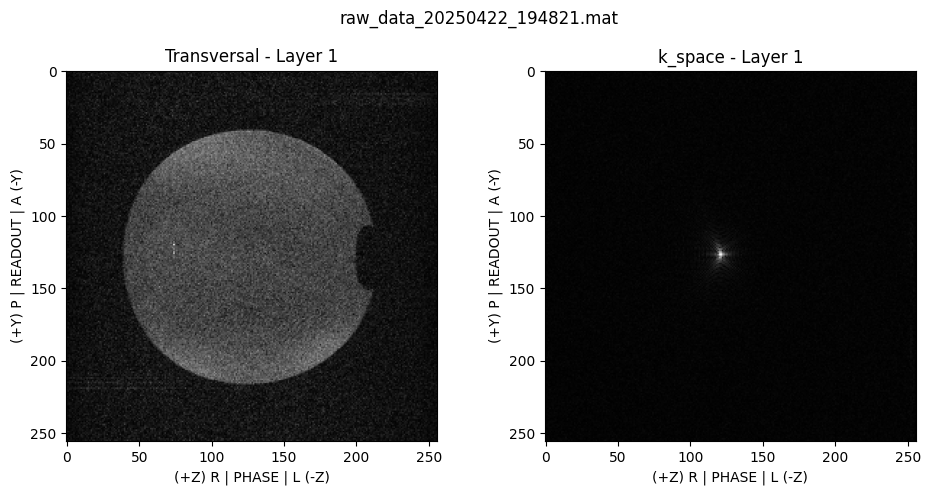

[{'widget': 'image',
  'data': array([[[2.45536176, 5.63039133, 3.15515259, ..., 4.91007651,
           3.41793161, 5.88771868],
          [4.6492354 , 6.17466729, 4.6327324 , ..., 2.98311912,
           1.40117806, 4.74563081],
          [5.32278037, 6.73841536, 6.73194016, ..., 2.74684794,
           6.51645694, 2.45002747],
          ...,
          [1.06823306, 4.16515518, 4.66939478, ..., 5.00909057,
           4.12705673, 3.75564214],
          [3.17150759, 7.60988156, 1.14979295, ..., 5.51211611,
           6.81379627, 1.58481206],
          [2.42025566, 1.92690607, 9.40750644, ..., 2.82070858,
           6.92545566, 4.76984151]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.97648469, -1.991981  , -1.98997921, ..., -1.96261527,
           -1.96888318, -1.98173354],
          [-1.97497437, -1.97565393, -1.98180787, ..., -1.95885355,
           -1.95872

In [32]:
#RG2: -10dB #NOW

seq = SEMultislicePSEQ(
    nScans=3,
    larmorFreq=10.53449,
    rfExFA=90,
    rfReFA=180,
    rfSincExTime=3.0,
    rfSincReTime=3.0,
    repetitionTime=300.0,
    echoTime=20.0,
    fovInPlane=[100, 100],
    thickness=6,
    sliceGap=1,
    dfov=[0.0, 0.0, 8.0],
    nPoints=[256, 256, 1],
    axesOrientation=[1, 2, 0],
    bandwidth=21.33333333333333333333,
    shimming=[0.0013, 0.0013, 0.0005],
    phaseCycleEx=[0, 180],
    DephTime=1.25,
    sliceGradComp=0.5,
    sliceSpoilComp=0,
    sliceSpoilCompRD=1,
    phaseGradComp=0,
    riseTime=0.5,

)

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 1.0 min 16.799999999999997 seconds
Acquisition bandwidth fixed to: 21.333 kHz
delay_1: namespace(type='delay', delay=0.0062499999999999995)
delay_2: namespace(type='delay', delay=0.0062499999999999995)
delay_TR: namespace(type='delay', delay=0.26899999999999996)
Creating batch_1.seq...
read 6 definitions, 2560 blocks, 2 shapes, 2 adc events, 3 rf events, 262 gradient shapes
batch_1.seq ready!
1 batches created with 65536 read points. Sequence ready!
Center frequecy set: 10.53497 MHz
Scan 1, batch 1/1 running...
Acquired points = 196608, Expected points = 196608
Scan 1, batch 1/1 ready!
------------ max abs value: 0.18193537345654112
Moved: raw_data_20250422_200521 to experiments/acquisitions/2025.04.22


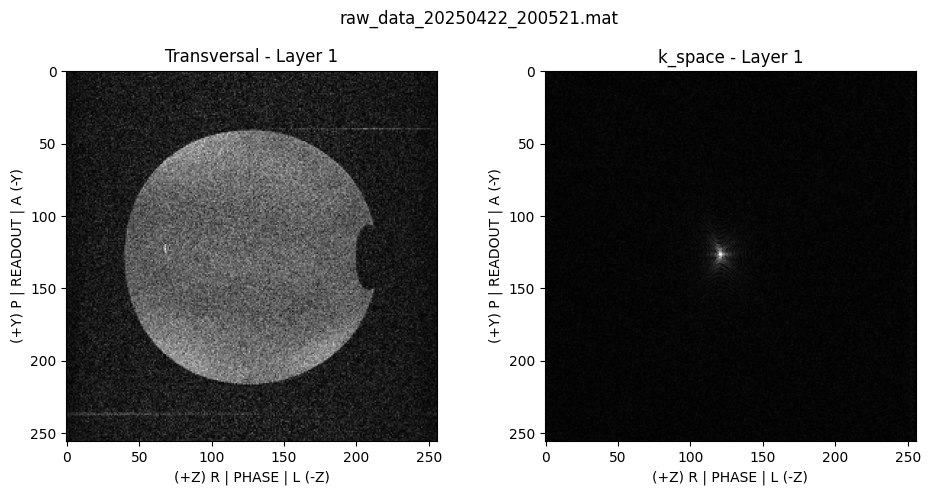

[{'widget': 'image',
  'data': array([[[ 2.9762627 ,  4.45888853,  6.57314513, ...,  5.13085467,
            6.97703294,  1.93486079],
          [ 8.3309995 , 10.10094418,  6.90642271, ..., 12.04011627,
           10.05486396,  5.65882901],
          [ 7.41734864,  6.52520229,  6.18081553, ...,  2.3624197 ,
            5.18021939,  5.39164189],
          ...,
          [13.09785905,  9.98947813,  4.04014806, ...,  2.46084858,
           12.68197764,  6.60115743],
          [ 6.32034636,  8.10078697,  4.66279638, ...,  6.44696078,
            8.82549417,  1.22227597],
          [ 1.77717918,  6.28398067,  2.31893783, ...,  9.10577167,
           14.81678631,  3.91252798]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.99291332, -1.97021925, -1.97791876, ..., -1.94298508,
           -1.95493428, -1.98871796],
          [-1.94657911, -1.9658678 , -1.9798176 , .

In [33]:
#tansuo: params

seq = SEMultislicePSEQ(
    nScans=1,
    larmorFreq=10.53497,
    rfExFA=90,
    rfReFA=180,
    rfSincExTime=3.0,
    rfSincReTime=3.0,
    repetitionTime=300.0,
    echoTime=20.0,
    fovInPlane=[100, 100],
    thickness=6,
    sliceGap=1,
    dfov=[0.0, 0.0, 8.0],
    nPoints=[256, 256, 1],
    axesOrientation=[1, 2, 0],
    bandwidth=21.33333333333333333333,
    shimming=[0.0013, 0.0013, 0.0005],
    phaseCycleEx=[0, 180],
    DephTime=1.25,
    sliceGradComp=0.5,
    sliceSpoilComp=0,
    sliceSpoilCompRD=1,
    phaseGradComp=1,
    riseTime=0.5,

)

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 4.0 min 16.0 seconds
Acquisition bandwidth fixed to: 21.333 kHz
delay_1: namespace(type='delay', delay=0.0062499999999999995)
delay_2: namespace(type='delay', delay=0.0062499999999999995)
delay_TR: namespace(type='delay', delay=0.372)
Creating batch_1.seq...
read 6 definitions, 1280 blocks, 2 shapes, 2 adc events, 3 rf events, 134 gradient shapes
batch_1.seq ready!
1 batches created with 16384 read points. Sequence ready!
Center frequecy set: 10.53572 MHz
Scan 1, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 1, batch 1/1 ready!
Scan 2, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 2, batch 1/1 ready!
Scan 3, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 3, batch 1/1 ready!
Scan 4, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 4, batch 1/1 ready!
Scan 5, batch 1/1 running...
Acquired points = 49152, Expected points = 49152
Scan 5, batch 1/1 ready!
---------

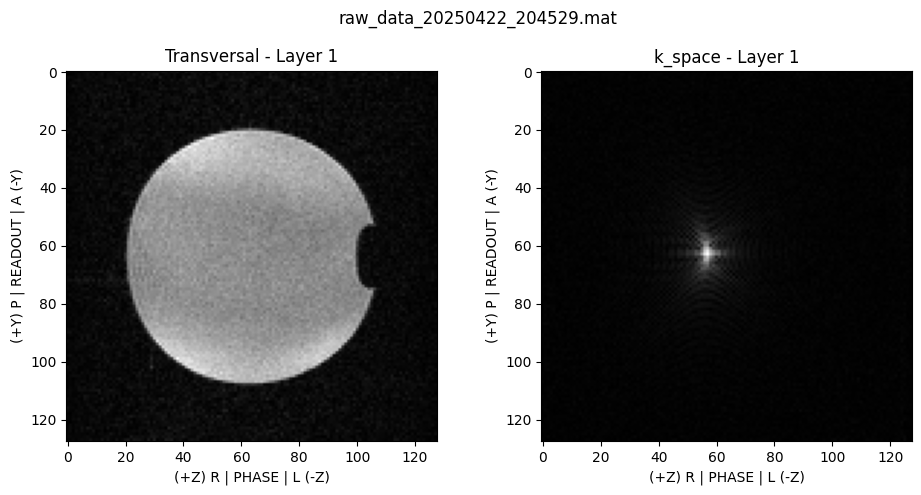

[{'widget': 'image',
  'data': array([[[2.39247896, 2.81947743, 1.62766081, ..., 0.97425295,
           2.25128592, 3.95199555],
          [0.57810774, 0.69603482, 1.33895933, ..., 1.40676373,
           1.72081586, 2.93284457],
          [4.5744355 , 3.9727676 , 3.17931915, ..., 2.43744201,
           3.64581081, 4.39726654],
          ...,
          [2.53537487, 2.17641761, 1.55874114, ..., 5.02702387,
           1.69596859, 5.17647319],
          [2.96016842, 3.19898813, 2.23826788, ..., 1.32192378,
           2.15336464, 0.62459622],
          [2.13567546, 1.9278525 , 3.46544905, ..., 0.75803377,
           2.68722946, 1.45119678]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.98191919, -1.9939599 , -1.98041001, ..., -1.98054219,
           -1.99574063, -1.99290637],
          [-1.98673725, -1.99518004, -1.98839705, ..., -1.99697584,
           -1.98713

In [34]:

seq = SEMultislicePSEQ(
    nScans=5,
    larmorFreq=10.53572,
    rfExFA=90,
    rfReFA=180,
    rfSincExTime=3.0,
    rfSincReTime=3.0,
    repetitionTime=400.0,
    echoTime=20.0,
    fovInPlane=[100, 100],
    thickness=5,
    sliceGap=1,
    dfov=[0.0, 0.0, 12.0],
    nPoints=[128, 128, 1],
    axesOrientation=[1, 2, 0],
    bandwidth=21.33333333333333333333,
    shimming=[0.0013, 0.0013, 0.0005],
    phaseCycleEx=[0, 180],
    DephTime=1.25,
    sliceGradComp=0.5,
    sliceSpoilComp=0,
    sliceSpoilCompRD=1,
    phaseGradComp=0,
    riseTime=0.5,

)

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')
